<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


In [1]:
# Загрузим все необходимые библиотеки

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import time
import os

from pandas import Series
import re

import json
import requests
import pandas_profiling
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')

from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from datetime import timedelta, datetime, date

from pandas import Series
from bs4 import BeautifulSoup

import seaborn as sn
%matplotlib inline
from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from datetime import date
from datetime import datetime, timedelta

from sklearn.preprocessing import PolynomialFeatures



In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

Сначала мы создаём список из доступных ссылок, что было проделано в google collab, в надежде,что найдутся сокомандники) (так и не нашлись, к сожалению) После этого мы прошлись по всем найденым ссылкам для получения необходимых данных, проделано в jupyter notebook. 

In [6]:
"""# загружаем необходимые библиотеки для получения и обработки данных

    import requests
    from bs4 import BeautifulSoup
    import csv
    import time
    import json
    import re
    import pandas as pd
   
    from google.colab import drive"""
  
    
"""drive.mount('/drive')


def get_all_links(url_list):
    
    #Функция для получения и сохранения в отдельный файл ссылок на объявления
    по машинам выбранных марок. В результате выполнения получаем файл со 
    списком найденных ссылок.


    all_car = []
    # проходимся по каждой выбранной марке
    # we go through each selected brand
    for url in url_list:
        # получаем количество страниц по выбранной марке
        # get the number of pages for the selected brand
        print(url)
        res = requests.get(url)
        soup = BeautifulSoup(res.content.decode('utf-8'), 'html.parser')
        news_blocks = soup.find('button',
                                class_='Button Button_color_blue Button_size_m Button_type_button Button_width_full')\
            .find('span', class_='ButtonWithLoader__content').text
        page_total = news_blocks.replace(u'\xa0', u' ').split()[1:3]
        page_total = int(''.join(page_total))
        # 38 ads on one page, get the number of pages
        number_of_pages = int(page_total / 38)

        # получаем и сохраняем ссылки по каждой машине из выбранной марки
        # get and save links for each car from the selected brand
        for i in range(1, number_of_pages):
            print('Current Page:', i, 'Total Pages:', number_of_pages)
            url_page = url + '/?page=' + str(i)
            res = requests.get(url)
            # задержка времени при отправке запросов/time delay when sending requests
            time.sleep(0.1)
            soup = BeautifulSoup(res.content.decode('utf-8'), 'html.parser')
            car_page = soup.find_all('a', class_='Link ListingItemTitle__link')
            car_list = list(map(lambda x: x.get('href'), car_page))
            for row in car_list:
                all_car.append(row)
    # записываем новую ссылку на объявление в файл
    # write the new link to the ad to a file
    with open('/drive/My Drive/all_car_27082021.csv', 'a') as myfile:
        wr = csv.writer(myfile)
        for row in all_car:
            wr.writerow([row])
    return all_car


# определяем список марок машин, которые нам интересны
# we define a list of car brands that are of interest to us
brands = ['honda', 'skoda', 'audi', 'volvo', 'bmw', 'nissan', 'infiniti',
          'mercedes', 'toyota', 'lexus', 'volkswagen', 'mitsubishi']
#url_list = ['https://auto.ru/moskva/cars/'+brand+'/all' for brand in brands]

url_list = ['https://auto.ru/cars/'+brand+'/all' for brand in brands]
all_car = get_all_links(url_list)
print(f'Количество отобранных объявлений: {len(all_car)}')"""



"131478 rows"

"df.to_csv('/drive/My Drive/lit_of_links.csv')"
 
    
    
"""# загружаем необходимые библиотеки для получения и обработки данных
# load the necessary libraries for receiving and processing data
import requests
from bs4 import BeautifulSoup
import csv
import time
import json
import re
import pandas as pd"""

"autoru_gdpr=1"

"""def get_cars_info(links, step=0):

    cars_info = pd.DataFrame()
    
    for link in links:
        try:
            response = requests.get(link)
            page = BeautifulSoup(response.content.decode('utf-8'), 'html.parser')
            print(f'link={link}, {response.status_code}')
        except:
            print(f'Error get link={link}')
            continue  
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            json_data = None
        try:
            catalog_url = page.find(
                'a', class_='Link SpoilerLink CardCatalogLink SpoilerLink_type_default').get('href')
            response_catalog = requests.get(catalog_url)
            page_catalog = BeautifulSoup(
                response_catalog.content.decode('utf-8'), 'html.parser')
        except:
            print(f'Error get link={link}')
            continue  
        try:
            json_data_catalog = json.loads(page_catalog.find(
                'script', type="application/json", id='initial-state').string)
        except:
            json_data_catalog = None
        try:
            json_data_equip = json.loads(
                page.find('script', type="application/json", id='initial-state').string)
        except:
            json_data_equip = None
        try:
            json_data['description'] = json_data['description'].replace(
                '\n', ' ')
            json_data['description'] = re.sub(
                '\W+', ' ', json_data['description'])
        except:
            json_data['description'] = ''
        try:
            options_dict = json_data_catalog['state']['compare']['selected'][0]['options']
            options_list = [key for key in list(
                options_dict.keys()) if options_dict[key] == 1]
        except:
            options_list = []
      
        try:
            car_url = json_data['offers']['url']
        except:
            car_url = None
        try:
            bodyType = json_data['bodyType']
        except:
            bodyType = None
        try:
            brand = json_data['brand']
        except:
            brand = None
        try:
            color = json_data['color']
        except:
            color = None
        try:
            complectation_dict = options_list
        except:
            complectation_dict = None
        try:
            description = json_data['description']
        except:
            description = None
        try:
            engineDisplacement = json_data['vehicleEngine']['engineDisplacement']
        except:
            engineDisplacement = None
        try:
            enginePower = json_data['vehicleEngine']['enginePower']
        except:
            enginePower = None
        try:
            equipment_dict = json_data_equip['card']['vehicle_info']['equipment']
        except:
            equipment_dict = None
        try:
            fuelType = json_data['fuelType']
        except:
            fuelType = None
        try:
            image = json_data['image']
        except:
            image = None
        try:
            mileage = page.find('li', class_='CardInfoRow CardInfoRow_kmAge').find_all(
                'span')[-1].text.replace(u'\xa0', u' ')
        except:
            mileage = None
        try:
            modelDate = json_data['modelDate']
        except:
            modelDate = None
        try:
            model_name = page.find_all(
                'div', class_='InfoPopup InfoPopup_theme_plain InfoPopup_withChildren BreadcrumbsPopup')[1].text
        except:
            model_name = None
        try:
            name = json_data['name']
        except:
            name = None
        try:
            numberOfDoors = json_data['numberOfDoors']
        except:
            numberOfDoors = None
        try:
            parsing_unixtime = int(time.time())
        except:
            parsing_unixtime = None
        try:
            price = json_data['offers']['price']
        except:
            price = None
        try:
            priceCurrency = json_data['offers']['priceCurrency']
        except:
            priceCurrency = None
        try:
            productionDate = json_data['productionDate']
        except:
            productionDate = None
        try:
            sell_id = page.find(
                'div', class_='CardHead__infoItem CardHead__id').text[2:]
        except:
            sell_id = None
        try:
            views = page.find(
                'div', class_='CardHead__infoItem CardHead__views').text.split()[0]
        except:
            views = None
        try:
            date_added = page.find(
                'div', class_='CardHead__infoItem CardHead__creationDate').text
        except:
            date_added = None
        try:
            super_gen = json.loads(
                page.find('div', id="sale-data-attributes").get('data-bem'))
        except:
            super_gen = None
        try:
            vehicleConfiguration = json_data['vehicleConfiguration']
        except:
            vehicleConfiguration = None
        try:
            vehicleTransmission = json_data['vehicleTransmission']
        except:
            vehicleTransmission = None
        try:
            Владельцы = page.find('li', class_='CardInfoRow CardInfoRow_ownersCount').find_all(
                'span')[-1].text.replace(u'\xa0', u' ')
        except:
            Владельцы = None
        try:
            Владение = page.find(
                'li', class_='CardInfoRow CardInfoRow_owningTime').find_all('span')[-1].text
        except:
            Владение = None
        try:
            ПТС = page.find('li', class_='CardInfoRow CardInfoRow_pts').find_all(
                'span')[-1].text
        except:
            ПТС = None
        try:
            Привод = page.find('li', class_='CardInfoRow CardInfoRow_drive').find_all(
                'span')[-1].text
        except:
            Привод = None
        try:
            Руль = page.find('li', class_='CardInfoRow CardInfoRow_wheel').find_all(
                'span')[-1].text
        except:
            Руль = None
        try:
            Состояние = page.find(
                'li', class_='CardInfoRow CardInfoRow_state').find_all('span')[-1].text
        except:
            Состояние = None
        try:
            Таможня = page.find(
                'li', class_='CardInfoRow CardInfoRow_customs').find_all('span')[-1].text
        except:
            Таможня = None
        try:
            region = page.find('div', class_='CardBreadcrumbs').find_all(
                'div', class_='CardBreadcrumbs__item')[-1].text.replace(u'\xa0', u' ')
        except:
            region = None

        row = {'car_url': car_url, 'bodyType': bodyType, 'brand': brand, 'color': color,
               'complectation_dict': complectation_dict, 'description': description,
               'engineDisplacement': engineDisplacement, 'enginePower': enginePower,
               'equipment_dict': equipment_dict, 'fuelType': fuelType, 'image': image,
               'mileage': mileage, 'modelDate': modelDate, 'model_name': model_name,
               'name': name, 'numberOfDoors': numberOfDoors, 'parsing_unixtime': parsing_unixtime,
               'price': price, 'priceCurrency': priceCurrency, 'productionDate': productionDate,
               'sell_id': sell_id, 'views': views, 'date_added': date_added,
               'super_gen': super_gen, 'vehicleConfiguration': vehicleConfiguration,
               'vehicleTransmission': vehicleTransmission, 'Владельцы': Владельцы,
               'Владение': Владение, 'ПТС': ПТС, 'Привод': Привод, 'Руль': Руль,
               'Состояние': Состояние, 'Таможня': Таможня, 'region': region}
        
        cars_info = pd.concat([cars_info, pd.DataFrame([row])])
        step += 1
        if step % 10 == 0:
            print(f'Completed {step} of total {len(links)}')
        else:
            continue
    return cars_info

df = pd.read_csv('lit_of_links.csv', sep=',', header=None)
all_links = df[1].tolist()"""


"""# проходимся по каждому объявлению из всего списка или выбранного диапозона,
# собираем данные по автомобилю и записываем их в файл
# we go through each ad from the entire list or the selected range,
# collect data on the car and write it to a file
car_data_1 = get_cars_info(all_links[:50000])
car_data_1.reset_index()
car_data_1.to_csv('all_car_1.csv')
car_data_2 = get_cars_info(all_links[50000:100000])
car_data_2.reset_index()
car_data_2.to_csv('all_car_2.csv')
car_data_3 = get_cars_info(all_links[100000:])
car_data_3.reset_index()
car_data_3.to_csv('all_car_3.csv')

df_1=pd.read_csv("all_car_1.csv")
df_2=pd.read_csv("all_car_2.csv")
df_3=pd.read_csv("all_car_3.csv")
all_car=pd.concat([df_1,df_2,df_3], sort=False, axis=0)
all_car.to_csv('all_cars.csv')"""

'# проходимся по каждому объявлению из всего списка или выбранного диапозона,\n# собираем данные по автомобилю и записываем их в файл\n# we go through each ad from the entire list or the selected range,\n# collect data on the car and write it to a file\ncar_data_1 = get_cars_info(all_links[:50000])\ncar_data_1.reset_index()\ncar_data_1.to_csv(\'all_car_1.csv\')\ncar_data_2 = get_cars_info(all_links[50000:100000])\ncar_data_2.reset_index()\ncar_data_2.to_csv(\'all_car_2.csv\')\ncar_data_3 = get_cars_info(all_links[100000:])\ncar_data_3.reset_index()\ncar_data_3.to_csv(\'all_car_3.csv\')\n\ndf_1=pd.read_csv("all_car_1.csv")\ndf_2=pd.read_csv("all_car_2.csv")\ndf_3=pd.read_csv("all_car_3.csv")\nall_car=pd.concat([df_1,df_2,df_3], sort=False, axis=0)\nall_car.to_csv(\'all_cars.csv\')'

# Setup

Изначально проводилось обучение только на спарсенных лично данных, но по какой-то причине в датасете было очень много дубликатов, скорее всего ошибка в самом парсинге. Поэтому используем также и датасет данный в baseline

In [7]:
VERSION    = 8
DIR_TRAIN  = '../input/all-cars/' # подключил к ноутбуку внешний датасет
DIR_TRAIN_base  = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [8]:
!ls '../input'

all-cars  parsing-all-moscow-auto-ru-09-09-2020  sf-dst-car-price-prediction


In [9]:
train = pd.read_csv(DIR_TRAIN+'all_cars.csv') # датасет для обучения модели
train_base  = pd.read_csv(DIR_TRAIN_base+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [10]:
train.head(5)

Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             0   
2           2             0   
3           3             0   
4           4             0   

                                             car_url           bodyType  \
0  https://auto.ru/cars/used/sale/honda/cr_v/1104...  внедорожник 5 дв.   
1  https://auto.ru/cars/used/sale/honda/accord/11...              седан   
2  https://auto.ru/cars/used/sale/honda/crosstour...  внедорожник 5 дв.   
3  https://auto.ru/cars/new/group/honda/cr_v/2252...  внедорожник 5 дв.   
4  https://auto.ru/cars/used/sale/honda/civic/110...              седан   

   brand   color                                 complectation_dict  \
0  HONDA   синий                                                 []   
1  HONDA   белый                                                 []   
2  HONDA  чёрный  ['cruise-control', 'multi-wheel', 'airbag-pass...   
3  HONDA  чёрный  ['cruise-control', 'eco-leather', 'multi-wheel...   
4  HONDA  чёрный  ['airbag-passenger', 'lock', 'electro-mirrors'...   

                                         description engineDisplacement  \
0  Автомобиль проверен и готов к эксплуатации Гар...            2.0 LTR   
1  В автосалон не поставлю СПОЙЛЕР ПРОДАН Собстве...            2.0 LTR   
2  Безопасность 8 Обзор 4 Комфорт 11 Элементы экс...            3.5 LTR   
3  Поставка в сентябре 2021г Доп оборудование на ...            2.4 LTR   
4  Один владелец Для данного автомобиля действует...            1.8 LTR   

  enginePower  ...           vehicleConfiguration vehicleTransmission  \
0     147 N12  ...  ALLROAD_5_DOORS AUTOMATIC 2.0      автоматическая   
1     150 N12  ...            SEDAN AUTOMATIC 2.0      автоматическая   
2     275 N12  ...  ALLROAD_5_DOORS AUTOMATIC 3.5      автоматическая   
3     186 N12  ...   ALLROAD_5_DOORS VARIATOR 2.4            вариатор   
4     140 N12  ...            SEDAN AUTOMATIC 1.8      автоматическая   

     Владельцы Владение       ПТС    Привод    Руль           Состояние  \
0  3 или более      NaN  Оригинал    полный   Левый  Не требует ремонта   
1  3 или более      NaN  Дубликат  передний  Правый  Не требует ремонта   
2  3 или более      NaN  Оригинал    полный   Левый  Не требует ремонта   
3          NaN      NaN       NaN       NaN     NaN                 NaN   
4   1 владелец      NaN  Оригинал  передний   Левый  Не требует ремонта   

      Таможня               region  
0  Растаможен            в Брянске  
1  Растаможен      в Екатеринбурге  
2  Растаможен               в Сочи  
3         NaN                  NaN  
4  Растаможен   в Санкт-Петербурге  

[5 rows x 36 columns]

Убираем ненужные колонки

In [11]:
train = train.drop('Unnamed: 0', 1)

In [12]:
train = train.drop('Unnamed: 0.1', 1)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125034 entries, 0 to 125033
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   car_url               125034 non-null  object 
 1   bodyType              125034 non-null  object 
 2   brand                 125034 non-null  object 
 3   color                 125034 non-null  object 
 4   complectation_dict    125034 non-null  object 
 5   description           125034 non-null  object 
 6   engineDisplacement    125034 non-null  object 
 7   enginePower           125034 non-null  object 
 8   equipment_dict        125034 non-null  object 
 9   fuelType              125034 non-null  object 
 10  image                 124881 non-null  object 
 11  mileage               99152 non-null   object 
 12  modelDate             125034 non-null  int64  
 13  model_name            99152 non-null   object 
 14  name                  125034 non-null  object 
 15  

In [14]:
# Смотрим совпадения по всем колонкам кроме patsing_unixtime

train.duplicated(subset=['car_url', 'bodyType', 'brand', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'price', 'priceCurrency',
       'productionDate', 'sell_id', 'views', 'date_added', 'super_gen',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'region']).sum()

105946

In [15]:
# Удаляем дубликаты

train.drop_duplicates(subset=['car_url', 'bodyType', 'brand', 'color', 'complectation_dict', 'description', 'engineDisplacement',
        'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_name', 'name', 'numberOfDoors', 'price',
        'priceCurrency', 'productionDate', 'sell_id', 'views', 'date_added', 'super_gen', 'vehicleConfiguration', 'vehicleTransmission',
        'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'region'], keep = 'first', inplace = True)

In [16]:
train

car_url           bodyType  \
0       https://auto.ru/cars/used/sale/honda/cr_v/1104...  внедорожник 5 дв.   
1       https://auto.ru/cars/used/sale/honda/accord/11...              седан   
2       https://auto.ru/cars/used/sale/honda/crosstour...  внедорожник 5 дв.   
3       https://auto.ru/cars/new/group/honda/cr_v/2252...  внедорожник 5 дв.   
4       https://auto.ru/cars/used/sale/honda/civic/110...              седан   
...                                                   ...                ...   
124961  https://auto.ru/cars/used/sale/mitsubishi/outl...  внедорожник 5 дв.   
124974  https://auto.ru/cars/used/sale/mitsubishi/paje...  внедорожник 5 дв.   
124979  https://auto.ru/cars/used/sale/mitsubishi/paje...  внедорожник 5 дв.   
124981  https://auto.ru/cars/used/sale/mitsubishi/outl...  внедорожник 5 дв.   
125031  https://auto.ru/cars/used/sale/mitsubishi/outl...  внедорожник 5 дв.   

             brand    color  \
0            HONDA    синий   
1            HONDA    белый   
2            HONDA   чёрный   
3            HONDA   чёрный   
4            HONDA   чёрный   
...            ...      ...   
124961  MITSUBISHI  красный   
124974  MITSUBISHI    белый   
124979  MITSUBISHI  бежевый   
124981  MITSUBISHI    синий   
125031  MITSUBISHI    серый   

                                       complectation_dict  \
0                                                      []   
1                                                      []   
2       ['cruise-control', 'multi-wheel', 'airbag-pass...   
3       ['cruise-control', 'eco-leather', 'multi-wheel...   
4       ['airbag-passenger', 'lock', 'electro-mirrors'...   
...                                                   ...   
124961  ['airbag-passenger', 'lock', 'electro-mirrors'...   
124974  ['cruise-control', 'multi-wheel', 'airbag-pass...   
124979  ['cruise-control', 'xenon', 'airbag-passenger'...   
124981  ['xenon', 'airbag-passenger', 'lock', 'electro...   
125031  ['airbag-passenger', 'lock', 'electro-mirrors'...   

                                              description engineDisplacement  \
0       Автомобиль проверен и готов к эксплуатации Гар...            2.0 LTR   
1       В автосалон не поставлю СПОЙЛЕР ПРОДАН Собстве...            2.0 LTR   
2       Безопасность 8 Обзор 4 Комфорт 11 Элементы экс...            3.5 LTR   
3       Поставка в сентябре 2021г Доп оборудование на ...            2.4 LTR   
4       Один владелец Для данного автомобиля действует...            1.8 LTR   
...                                                   ...                ...   
124961  Код автомобиля Ю 73 Автомобиль принят по прогр...            2.0 LTR   
124974  Автомобиль был принят в зачет по программе Tra...            3.0 LTR   
124979  Автомобиль приобретался у официального дилера ...            3.8 LTR   
124981  В продажу поступил MITSUBISHI OUTLANDER Оригин...            2.4 LTR   
125031  Продажа от официального дилера ГК АВТОМИР Авто...            2.0 LTR   

       enginePower                                     equipment_dict  \
0          147 N12  {'alloy-wheel-disks': True, 'condition': True,...   
1          150 N12  {'engine-proof': True, 'tinted-glass': True, '...   
2          275 N12  {'cruise-control': True, 'esp': True, 'airbag-...   
3          186 N12  {'cruise-control': True, 'asr': True, 'tinted-...   
4          140 N12  {'esp': True, 'airbag-driver': True, 'electro-...   
...            ...                                                ...   
124961     146 N12  {'cruise-control': True, 'esp': True, 'airbag-...   
124974     178 N12  {'asr': True, 'tinted-glass': True, 'esp': Tru...   
124979     250 N12  {'cruise-control': True, 'engine-proof': True,...   
124981     170 N12  {'esp': True, 'airbag-driver': True, 'electro-...   
125031     146 N12  {'airbag-driver': True, 'isofix': True, 'usb':...   

       fuelType  ...           vehicleConfiguration vehicleTransmission  \
0        бензин  ...  ALLROAD_5_DOORS AUTOMATIC 2.0      автоматическа

In [17]:
train_base.head(5)

bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission  ...  Руль  Состояние Владельцы        ПТС Таможня  \
0          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
1          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
2          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
3          MECHANICAL  ...  LEFT        NaN       3.0   ORIGINAL    True   
4          MECHANICAL  ...  LEFT        NaN       3.0  DUPLICATE    True   

  Владение     price            start_date  hidden model  
0      NaN  200000.0  2019-10-03T08:09:11Z     NaN   100  
1      NaN   60000.0  2020-09-06T06:49:40Z     NaN   100  
2      NaN   99000.0  2020-09-02T14:04:21Z     NaN   100  
3      NaN   65000.0  2020-08-23T17:40:09Z     NaN   100  
4      NaN  100000.0  2020-09-08T09:22:07Z     NaN   100  

[5 rows x 26 columns]

In [18]:
train_base.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [19]:
train_base.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')

In [20]:
train_base.drop_duplicates(subset=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'], keep = 'first', inplace = True)

In [21]:
train_base

bodyType       brand   color fuelType  modelDate  \
0                Седан        AUDI  040001   бензин     1990.0   
1                Седан        AUDI  EE1D19   бензин     1982.0   
2      Универсал 5 дв.        AUDI  0000CC   бензин     1988.0   
3                Седан        AUDI  CACECB   бензин     1988.0   
4                Седан        AUDI  040001   бензин     1990.0   
...                ...         ...     ...      ...        ...   
89373          Минивэн  SSANG_YONG  040001   дизель     2004.0   
89374          Минивэн  SSANG_YONG  CACECB   дизель     2004.0   
89375          Минивэн  SSANG_YONG  040001   дизель     2013.0   
89376          Минивэн  SSANG_YONG  97948F   дизель     2013.0   
89377          Минивэн  SSANG_YONG  FAFBFB   дизель     2013.0   

                         name  numberOfDoors  productionDate  \
0       2.8 MT (174 л.с.) 4WD            4.0            1991   
1            1.8 MT (90 л.с.)            4.0            1986   
2       2.3 MT (136 л.с.) 4WD            5.0            1989   
3            1.8 MT (90 л.с.)            4.0            1989   
4           2.0 MT (101 л.с.)            4.0            1991   
...                       ...            ...             ...   
89373  2.7d AT (163 л.с.) 4WD            5.0            2006   
89374  2.7d AT (163 л.с.) 4WD            5.0            2007   
89375  2.0d AT (149 л.с.) 4WD            5.0            2014   
89376  2.0d AT (149 л.с.) 4WD            5.0            2013   
89377  2.0d AT (149 л.с.) 4WD            5.0            2014   

               vehicleConfiguration vehicleTransmission  ...  Руль  Состояние  \
0              SEDAN MECHANICAL 2.8          MECHANICAL  ...  LEFT        NaN   
1              SEDAN MECHANICAL 1.8          MECHANICAL  ...  LEFT        NaN   
2      WAGON_5_DOORS MECHANICAL 2.3          MECHANICAL  ...  LEFT        NaN   
3              SEDAN MECHANICAL 1.8          MECHANICAL  ...  LEFT        NaN   
4              SEDAN MECHANICAL 2.0          MECHANICAL  ...  LEFT        NaN   
...                             ...                 ...  ...   ...        ...   
89373        MINIVAN AUTOMATIC 2.7d           AUTOMATIC  ...  LEFT        NaN   
89374        MINIVAN AUTOMATIC 2.7d           AUTOMATIC  ...  LEFT        NaN   
89375        MINIVAN AUTOMATIC 2.0d           AUTOMATIC  ...  LEFT        NaN   
89376        MINIVAN AUTOMATIC 2.0d           AUTOMATIC  ...  LEFT        NaN   
89377        MINIVAN AUTOMATIC 2.0d           AUTOMATIC  ...  LEFT        NaN   

      Владельцы        ПТС Таможня                     Владение      price  \
0           3.0   ORIGINAL    True                          NaN   200000.0   
1           3.0   ORIGINAL    True                          NaN    60000.0   
2           3.0   ORIGINAL    True                          NaN    99000.0   
3           3.0   ORIGINAL    True                          NaN    65000.0   
4           3.0  DUPLICATE    True                          NaN   100000.0   
...         ...        ...     ...                          ...        ...   
89373       3.0   ORIGINAL    True                          NaN   450000.0   
89374       3.0   ORIGINAL    True   {'year': 2017, 'month': 2}   485000.0   
89375       1.0   ORIGINAL    True  {'year': 2015, 'month': 12}  1090000.0   
89376       3.0   ORIGINAL    True  {'year': 2017, 'month': 10}  1180000.0   
89377       2.0   ORIGINAL    True   {'year': 2018, 'month': 6}  1075000.0   

                 start_date  hidden   model  
0      2019-10-03T08:09:11Z     NaN     100  
1      2020-09-06T06:49:40Z     NaN     100  
2      2020-09-02T14:04:21Z     NaN     100  
3      2020-08-23T17:40:09Z     NaN     100  
4      2020-09-08T09:22:07Z     NaN     100  
...                     ...     ...     ...  
89373  2020-02-11T09:29:59Z     NaN  RODIUS  
89374  2020-05-30T18:56:30Z     NaN  RODIUS  
89375  2020-08-30T14:39:15Z     NaN  STAVIC  
89376  2019-05-14T15:43:20Z     NaN  STAVIC  
89377  2020-08-10T11:30:29Z     NaN 

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [23]:
test.sample(10)

bodyType       brand  \
14845              седан    INFINITI   
15750  внедорожник 5 дв.    MERCEDES   
4403               седан        AUDI   
17103              седан    MERCEDES   
17725    универсал 5 дв.    MERCEDES   
12731  внедорожник 5 дв.      NISSAN   
409              лифтбек       SKODA   
23999            минивэн  VOLKSWAGEN   
15886               купе    MERCEDES   
21663    универсал 5 дв.      TOYOTA   

                                                 car_url        color  \
14845  https://auto.ru/cars/used/sale/infiniti/q70/10...        белый   
15750  https://auto.ru/cars/used/sale/mercedes/g_klas...       чёрный   
4403   https://auto.ru/cars/used/sale/audi/100/109420...  серебристый   
17103  https://auto.ru/cars/used/sale/mercedes/s_klas...       чёрный   
17725  https://auto.ru/cars/used/sale/mercedes/cls_kl...       чёрный   
12731  https://auto.ru/cars/used/sale/nissan/murano/1...       чёрный   
409    https://auto.ru/cars/used/sale/skoda/octavia/1...        серый   
23999  https://auto.ru/cars/used/sale/volkswagen/mult...       чёрный   
15886  https://auto.ru/cars/used/sale/mercedes/s_klas...        белый   
21663  https://auto.ru/cars/used/sale/toyota/avensis/...        серый   

                                      complectation_dict  \
14845  {"id":"20661009","name":"Premium","available_o...   
15750                                                NaN   
4403                                                 NaN   
17103                                                NaN   
17725                                                NaN   
12731                                                NaN   
409    {"id":"4562901","name":"Ambition","available_o...   
23999                                                NaN   
15886  {"id":"21360773","name":"AMG S 63 4MATIC+ Купе...   
21663                                                NaN   

                                             description engineDisplacement  \
14845  Своевременное обслуживание. Куплена не в креди...            2.5 LTR   
15750  ПРОДАЕТСЯ ОЧЕНЬ КРАСИВЫЙ ЛЕГЕНДАРНЫЙ  MERCEDES...            5.5 LTR   
4403   Продаю Ауди 100 в хорошем техническом состояни...            2.8 LTR   
17103  Автомобиль в хорошем состоянии. Без вложений. ...            3.5 LTR   
17725  ВСЁ (кузов, двигатель, трансмиссия, салон) в и...            3.0 LTR   
12731  • Автомобиль проверен по 110 пунктам\n• Автокр...            3.5 LTR   
409    Могу сказать с уверенностью, что машина в хоро...            1.6 LTR   
23999  Полностью обслужен. Оригинальный пробег. Богат...            2.0 LTR   
15886  Идеальное состояние. В заводском окрасе. Весь ...            4.0 LTR   
21663  Автомобиль в хорошем состоянии. Полная комплек...            2.0 LTR   

      enginePower                                     equipment_dict fuelType  \
14845     221 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
15750     571 N12  {"tinted-glass":true,"esp":true,"adaptive-ligh...   бензин   
4403      174 N12                                                NaN   бензин   
17103     306 N12                                                NaN   бензин   
17725     333 N12  {"asr":true,"tinted-glass":true,"esp":true,"ad...   бензин   
12731     249 N12  {"cruise-control":true,"asr":true,"tinted-glas...   бензин   
409       102 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
23999     180 N12  {"navigation":true,"ptf":true,"rain-sensor":tr...   дизель   
15886     612 N12  {"cruise-control":true,"esp":true,"adaptive-li...   бензин   
21663     147 N12  {"cruise-control":true,"feedback-alarm":true,"...   бензин   

       ...           vehicleConfiguration  vehicleTransmission    vendor  \
14845  ...            SEDAN AUTOMATIC 2.5       автоматическая  JAPANESE   
15750  ...  ALLROAD_5_DOORS AUTOMATIC 5.5       автоматическая  EUROPEAN   
4403   ...            SEDAN AUTOMATIC 2.8       автоматическая  EUROPEAN   
17103  ...            SEDAN AUTOMATIC 3.5   

In [24]:
test.duplicated(subset=['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня']).sum()

0

In [25]:
# определяем, какие столбцы не вошли в датасет
drop_columns = []
for i in train_base.columns:
    if i not in train.columns:
        drop_columns.append(i)

In [26]:
drop_columns_2 = []
for i in train.columns:
    if i not in train_base.columns:
        drop_columns_2.append(i)

In [27]:
drop_columns_3 = []
for i in test.columns:
    if i not in train.columns:
        drop_columns_3.append(i)

In [28]:
drop_columns_4 = []
for i in train.columns:
    if i not in test.columns:
        drop_columns_4.append(i)

In [29]:
drop_columns_5 = []
for i in test.columns:
    if i not in train_base.columns:
        drop_columns_5.append(i)

In [30]:
drop_columns_6 = []
for i in train_base.columns:
    if i not in train.columns:
        drop_columns_6.append(i)

In [31]:
train_base.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')

In [32]:
train.columns

Index(['car_url', 'bodyType', 'brand', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_name', 'name',
       'numberOfDoors', 'parsing_unixtime', 'price', 'priceCurrency',
       'productionDate', 'sell_id', 'views', 'date_added', 'super_gen',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'region'],
      dtype='object')

In [33]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

In [34]:
# активируем функцию
drop_columns

['Комплектация', 'start_date', 'hidden', 'model']

In [35]:
drop_columns_2

['car_url',
 'complectation_dict',
 'equipment_dict',
 'image',
 'model_name',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'views',
 'date_added',
 'super_gen',
 'region']

In [36]:
drop_columns_3

['model_info', 'vendor']

In [37]:
drop_columns_4

['price', 'views', 'date_added', 'region']

In [38]:
drop_columns_5

['car_url',
 'complectation_dict',
 'equipment_dict',
 'image',
 'model_info',
 'model_name',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen',
 'vendor']

In [39]:
drop_columns_6

['Комплектация', 'start_date', 'hidden', 'model']

In [40]:
train_base.Комплектация.sample(10)

38136    {'id': '20769401', 'name': 'Comfort', 'availab...
35663                                          {'id': '0'}
75682                                          {'id': '0'}
61638                                          {'id': '0'}
23478                {'id': '0', 'name': 'Индивидуальная'}
46111    {'id': '21000598', 'name': 'Comfort A/C', 'ava...
4433     {'id': '21765705', 'name': '218i M Sport Pro',...
51282    {'id': '21436675', 'name': 'SE+', 'available_o...
14964                                          {'id': '0'}
3032     {'id': '21680454', 'name': 'Design 40 TFSI qua...
Name: Комплектация, dtype: object

In [41]:
train_base['Комплектация'].iloc[7318]

"{'id': '22261477', 'name': '630d xDrive M Sport Pro', 'available_options': ['multi-wheel', 'auto-park', 'airbag-passenger', 'navigation', 'decorative-interior-lighting', 'bas', 'lock', 'electro-mirrors', 'easy-trunk-opening', 'mirrors-heat', 'power-latching-doors', 'leather', 'driver-seat-memory', 'body-kit', 'glonass', 'front-seats-heat-vent', 'automatic-lighting-control', 'passenger-seat-updown', 'collision-prevention-assist', 'computer', 'high-beam-assist', 'seat-transformation', 'airbag-side', 'electronic-gage-panel', 'electro-trunk', 'auto-cruise', 'abs', 'wheel-leather', 'auto-mirrors', 'black-roof', 'asr', 'esp', 'adaptive-light', 'usb', 'audiosystem-tv', 'front-centre-armrest', 'front-seat-support', '20-inch-wheels', 'air-suspension', 'servo', 'drl', 'steering-wheel-gear-shift-paddles', 'electro-window-back', 'multizone-climate-control', 'park-assist-f', 'wheel-heat', 'led-lights', 'music-super', 'park-assist-r', 'knee-airbag', 'wireless-charger', 'airbag-driver', 'aux', 'proj

Здесь много информации и той, которая есть в других колонках и уникальная, в дальнейшим возможно стоит поработать с этим признаком, но на данный момент удаляем

In [42]:
train_base = train_base.drop('Комплектация', 1) 

In [43]:
train_base.start_date.sample(3)

40370    2020-08-19T06:50:20Z
17420    2020-08-23T07:23:31Z
81101    2019-09-26T12:00:54Z
Name: start_date, dtype: object

Тоже самое, что и date_added в test

In [44]:
train['date_added'].sample(3)

295      14 сентября
31213    27 сентября
72997    29 сентября
Name: date_added, dtype: object

In [45]:
train_base.hidden.sample(3)

63692   NaN
58577   NaN
23796   NaN
Name: hidden, dtype: float64

полностью пустой признак, удаляем

In [46]:
train_base = train_base.drop('hidden', 1) 

In [47]:
train_base.model.sample(3)

2193       A6
70305    GOLF
4407      2ER
Name: model, dtype: object

тоже самое, что и model_name в test и train, надо переименовать

In [48]:
train_base = train_base.rename(columns={'model': 'model_name'})

In [49]:
train.complectation_dict.sample(10)

33911     ['cruise-control', 'sport-seats', 'multi-wheel...
102729    ['multi-wheel', 'heated-wash-system', 'airbag-...
76482     ['cruise-control', 'multi-wheel', 'xenon', 'ai...
46940     ['cruise-control', 'multi-wheel', 'airbag-pass...
76367     ['multi-wheel', 'airbag-passenger', 'bas', 'lo...
11878     ['cruise-control', 'heated-wash-system', 'airb...
79495     ['airbag-passenger', 'lock', 'electro-mirrors'...
56228     ['cruise-control', 'multi-wheel', 'airbag-pass...
55566                                                    []
114136    ['airbag-passenger', 'lock', 'electro-mirrors'...
Name: complectation_dict, dtype: object

In [50]:
train.equipment_dict.sample(10)

36208     {'cruise-control': True, 'tinted-glass': True,...
13925     {'cruise-control': True, 'asr': True, 'tinted-...
106709    {'cruise-control': True, 'asr': True, 'tinted-...
51258     {'cruise-control': True, 'asr': True, 'tinted-...
2         {'cruise-control': True, 'esp': True, 'airbag-...
9021      {'cruise-control': True, 'esp': True, 'adaptiv...
20764     {'multi-wheel': True, 'heated-wash-system': Tr...
40984     {'engine-proof': True, 'tinted-glass': True, '...
58955     {'cruise-control': True, 'asr': True, 'esp': T...
114528    {'wireless-charger': True, 'airbag-driver': Tr...
Name: equipment_dict, dtype: object

In [51]:
train.super_gen.sample(10)

13323     {'sale-data-attributes': {'asciiCat': 'cars', ...
63786     {'sale-data-attributes': {'asciiCat': 'cars', ...
34687     {'sale-data-attributes': {'asciiCat': 'cars', ...
115190    {'sale-data-attributes': {'asciiCat': 'cars', ...
39923     {'sale-data-attributes': {'asciiCat': 'cars', ...
57635     {'sale-data-attributes': {'asciiCat': 'cars', ...
57363     {'sale-data-attributes': {'asciiCat': 'cars', ...
95676     {'sale-data-attributes': {'asciiCat': 'cars', ...
67660     {'sale-data-attributes': {'asciiCat': 'cars', ...
34058     {'sale-data-attributes': {'asciiCat': 'cars', ...
Name: super_gen, dtype: object

In [52]:
test['vendor'].sample(10)

9786     EUROPEAN
30737    EUROPEAN
11219    JAPANESE
31477    EUROPEAN
20996    JAPANESE
2616     EUROPEAN
28662    JAPANESE
30985    EUROPEAN
15680    EUROPEAN
4216     EUROPEAN
Name: vendor, dtype: object

Данную информацию мы не собрали при парсинге, при этом логически, марки машин отчасти показывают страну производства, поэтому пока можем удалить этот столбец. В дальнейшим, можем добавить информацию, анализирую марки машин

In [53]:
test = test.drop('vendor', 1) 

In [54]:
test['model_info'].sample(10)

18233    {"code":"GLE_KLASSE_COUPE_AMG","name":"GLE Cou...
14636    {"code":"PRIMERA","name":"Primera","ru_name":"...
9763     {"code":"5ER","name":"5 серии","ru_name":"5 се...
3808     {"code":"A3","name":"A3","ru_name":"А3","morph...
14942    {"code":"QX70","name":"QX70","ru_name":"ку икс...
19738    {"code":"FJ_CRUISER","name":"FJ Cruiser","ru_n...
30916    {"code":"PASSAT","name":"Passat","ru_name":"Па...
17855    {"code":"S_KLASSE","name":"S-Класс","ru_name":...
24867    {"code":"PASSAT","name":"Passat","ru_name":"Па...
25634    {"code":"PASSAT","name":"Passat","ru_name":"Па...
Name: model_info, dtype: object

Данная информация есть в других ячейках, можем удалить. В дальнейшим мы увидем, что есть пропуски по моделям машин, опять же можно было бы проверить наличие данной информации в данном столбце, как будет больше времени, надо будет вернуться к этому

In [55]:
test = test.drop('model_info', 1)

Переменные views, region и date_added могут быть полезны, если в дальнейшим тестовая выборка пополнится данными признаками, но пока удаляем их

In [56]:
train['views'].sample(10)

31354      805.0
54885        NaN
62062      347.0
81920      603.0
63216      342.0
28405      186.0
110966     290.0
17498     1330.0
111097     573.0
76518      160.0
Name: views, dtype: float64

In [57]:
train = train.drop('views', 1)

In [58]:
train = train.drop('date_added', 1)

In [59]:
train_base = train_base.drop('start_date', 1)

In [60]:
train['region'].sample(10)

85907          в Москве
109743         в Москве
62103          в Москве
71675          в Москве
28905      в Краснодаре
36866          в Москве
113699         в Москве
113492         в Москве
21569          в Тюмени
22941          в Москве
Name: region, dtype: object

In [61]:
train = train.drop('region', 1)

In [62]:
train_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87264 entries, 0 to 89377
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              87263 non-null  object 
 1   brand                 87264 non-null  object 
 2   color                 87264 non-null  object 
 3   fuelType              87264 non-null  object 
 4   modelDate             87263 non-null  float64
 5   name                  87263 non-null  object 
 6   numberOfDoors         87263 non-null  float64
 7   productionDate        87264 non-null  int64  
 8   vehicleConfiguration  87263 non-null  object 
 9   vehicleTransmission   87263 non-null  object 
 10  engineDisplacement    87263 non-null  object 
 11  enginePower           87263 non-null  float64
 12  description           84031 non-null  object 
 13  mileage               87264 non-null  int64  
 14  Привод                87263 non-null  object 
 15  Руль               

## Price

In [63]:
train['price'].value_counts()

1195000.0    281
1245000.0    216
660000.0     186
1690000.0    178
165000.0     168
            ... 
2727000.0      1
1790000.0      1
2970000.0      1
1270000.0      1
1997000.0      1
Name: price, Length: 1172, dtype: int64

In [64]:
train['price'].isnull().sum()

2230

Так как цена наш целевой признак, мы удаляем строки, в которых нет цены

In [65]:
train.dropna(subset=['price'], inplace=True)

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16858 entries, 0 to 125031
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   car_url               16858 non-null  object 
 1   bodyType              16858 non-null  object 
 2   brand                 16858 non-null  object 
 3   color                 16858 non-null  object 
 4   complectation_dict    16858 non-null  object 
 5   description           16858 non-null  object 
 6   engineDisplacement    16858 non-null  object 
 7   enginePower           16858 non-null  object 
 8   equipment_dict        16858 non-null  object 
 9   fuelType              16858 non-null  object 
 10  image                 16854 non-null  object 
 11  mileage               15622 non-null  object 
 12  modelDate             16858 non-null  int64  
 13  model_name            15622 non-null  object 
 14  name                  16858 non-null  object 
 15  numberOfDoors     

In [67]:
train

car_url           bodyType  \
0       https://auto.ru/cars/used/sale/honda/cr_v/1104...  внедорожник 5 дв.   
1       https://auto.ru/cars/used/sale/honda/accord/11...              седан   
2       https://auto.ru/cars/used/sale/honda/crosstour...  внедорожник 5 дв.   
3       https://auto.ru/cars/new/group/honda/cr_v/2252...  внедорожник 5 дв.   
4       https://auto.ru/cars/used/sale/honda/civic/110...              седан   
...                                                   ...                ...   
124961  https://auto.ru/cars/used/sale/mitsubishi/outl...  внедорожник 5 дв.   
124974  https://auto.ru/cars/used/sale/mitsubishi/paje...  внедорожник 5 дв.   
124979  https://auto.ru/cars/used/sale/mitsubishi/paje...  внедорожник 5 дв.   
124981  https://auto.ru/cars/used/sale/mitsubishi/outl...  внедорожник 5 дв.   
125031  https://auto.ru/cars/used/sale/mitsubishi/outl...  внедорожник 5 дв.   

             brand    color  \
0            HONDA    синий   
1            HONDA    белый   
2            HONDA   чёрный   
3            HONDA   чёрный   
4            HONDA   чёрный   
...            ...      ...   
124961  MITSUBISHI  красный   
124974  MITSUBISHI    белый   
124979  MITSUBISHI  бежевый   
124981  MITSUBISHI    синий   
125031  MITSUBISHI    серый   

                                       complectation_dict  \
0                                                      []   
1                                                      []   
2       ['cruise-control', 'multi-wheel', 'airbag-pass...   
3       ['cruise-control', 'eco-leather', 'multi-wheel...   
4       ['airbag-passenger', 'lock', 'electro-mirrors'...   
...                                                   ...   
124961  ['airbag-passenger', 'lock', 'electro-mirrors'...   
124974  ['cruise-control', 'multi-wheel', 'airbag-pass...   
124979  ['cruise-control', 'xenon', 'airbag-passenger'...   
124981  ['xenon', 'airbag-passenger', 'lock', 'electro...   
125031  ['airbag-passenger', 'lock', 'electro-mirrors'...   

                                              description engineDisplacement  \
0       Автомобиль проверен и готов к эксплуатации Гар...            2.0 LTR   
1       В автосалон не поставлю СПОЙЛЕР ПРОДАН Собстве...            2.0 LTR   
2       Безопасность 8 Обзор 4 Комфорт 11 Элементы экс...            3.5 LTR   
3       Поставка в сентябре 2021г Доп оборудование на ...            2.4 LTR   
4       Один владелец Для данного автомобиля действует...            1.8 LTR   
...                                                   ...                ...   
124961  Код автомобиля Ю 73 Автомобиль принят по прогр...            2.0 LTR   
124974  Автомобиль был принят в зачет по программе Tra...            3.0 LTR   
124979  Автомобиль приобретался у официального дилера ...            3.8 LTR   
124981  В продажу поступил MITSUBISHI OUTLANDER Оригин...            2.4 LTR   
125031  Продажа от официального дилера ГК АВТОМИР Авто...            2.0 LTR   

       enginePower                                     equipment_dict  \
0          147 N12  {'alloy-wheel-disks': True, 'condition': True,...   
1          150 N12  {'engine-proof': True, 'tinted-glass': True, '...   
2          275 N12  {'cruise-control': True, 'esp': True, 'airbag-...   
3          186 N12  {'cruise-control': True, 'asr': True, 'tinted-...   
4          140 N12  {'esp': True, 'airbag-driver': True, 'electro-...   
...            ...                                                ...   
124961     146 N12  {'cruise-control': True, 'esp': True, 'airbag-...   
124974     178 N12  {'asr': True, 'tinted-glass': True, 'esp': Tru...   
124979     250 N12  {'cruise-control': True, 'engine-proof': True,...   
124981     170 N12  {'esp': True, 'airbag-driver': True, 'electro-...   
125031     146 N12  {'airbag-driver': True, 'isofix': True, 'usb':...   

       fuelType  ...                                          super_gen  \
0        бензин  ...  {'sale-data-attributes': {'asciiCat': 'cars', ..

In [68]:
train.price.describe()

count    1.685800e+04
mean     2.491070e+06
std      2.511004e+06
min      5.000000e+04
25%      9.990000e+05
50%      1.559000e+06
75%      3.280000e+06
max      2.980000e+07
Name: price, dtype: float64

In [69]:
train['price'].sort_values()

13467       50000.0
13423       50000.0
13384       50000.0
13277       50000.0
25167       74000.0
            ...    
65974    22988600.0
66278    22988600.0
71987    25900000.0
71984    28700000.0
71986    29800000.0
Name: price, Length: 16858, dtype: float64

In [70]:
train_base['price'].value_counts()

450000.0     1208
350000.0     1040
250000.0      986
550000.0      962
650000.0      937
             ... 
2295100.0       1
6015300.0       1
23000.0         1
7736100.0       1
3670000.0       1
Name: price, Length: 8168, dtype: int64

In [71]:
train_base['price'].isnull().sum()

410

In [72]:
train_base.dropna(subset=['price'], inplace=True)

In [73]:
train_base.price.describe()

count    8.685400e+04
mean     1.260892e+06
std      1.923665e+06
min      1.600000e+04
25%      3.500000e+05
50%      6.490000e+05
75%      1.400000e+06
max      9.900000e+07
Name: price, dtype: float64

In [74]:
train_base['price'].sort_values()

57256       16000.0
30232       20000.0
60216       20000.0
17470       21000.0
70782       23000.0
            ...    
86882    59087576.0
86878    59087576.0
86874    65435792.0
87213    68500000.0
56585    99000000.0
Name: price, Length: 86854, dtype: float64

## Data Preprocessing


In [75]:
# список числовых переменных
num_cols = []
# список категориальных переменных
cat_cols = []
# список бинарных переменных
bin_cols = []

In [76]:
train['sample'] = 1 # помечаем, где у нас трейн
train_base['sample'] = 1 # помечаем, где у нас трейн
test['sample'] = 0 # помечаем, где у нас тест
test['price'] = 0 # значение целевой переменной отсутствует для тестовой выборки
data = test.append(train, sort=False).reset_index(drop=True)

In [77]:
data.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

   ... vehicleTransmission    Владельцы  Владение       ПТС    Привод   Руль  \
0  ...    роботизированная  3 или более       NaN  Оригинал  передний  Левый   
1  ...        механическая   1 владелец       NaN  Оригинал  передний  Левый   
2  ...    роботизированная   1 владелец       NaN  Оригинал  передний  Левый   
3  ...      автоматическая   1 владелец       NaN  Оригинал  передний  Левый   
4  ...      автоматическая   1 владелец       NaN  Оригинал  передний  Левый   

            Состояние     Таможня  sample  price  
0  Не требует ремонта  Растаможен       0    0.0  
1  Не требует ремонта  Растаможен       0    0.0  
2  Не требует ремонта  Растаможен       0    0.0  
3  Не требует ремонта  Растаможен       0    0.0  
4  Не требует ремонта  Растаможен       0    0.0  

[5 rows x 32 columns]

Я сначала соединила test и train, чтобы проверить, есть ли дубликаты по sell_id. Так как в train_base такого значения нет, то при объединение они одинаково заполнятся na

In [78]:
data.duplicated(subset=['sell_id']).sum()

15311

In [79]:
# Оставляем первые дубликаты, так как они тестовые
data.drop_duplicates(subset=['sell_id'], keep = 'first', inplace = True)

In [80]:
data=data.append(train_base, sort=False).reset_index(drop=True)

In [81]:
#Приведём колонки к одному виду названий
data.rename(columns={'bodyType': 'body_type',
                   'engineDisplacement': 'engine_displacement',
                   'enginePower': 'engine_power',
                   'fuelType': 'fuel_type',
                   'modelDate': 'model_date',
                   'numberOfDoors': 'number_of_doors',
                   'productionDate': 'production_date',
                   'vehicleConfiguration': 'vehicle_configuration',
                   'vehicleTransmission': 'vehicle_transmission',
                   'Владельцы': 'owners',
                   'Владение': 'ownership_time',
                   'ПТС': 'licence',
                   'Привод': 'type_of_drive',
                   'Руль': 'steering_wheel',
                    'Таможня': 'сustoms',
                    'Состояние': 'condition'
                    }, inplace=True)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123087 entries, 0 to 123086
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   body_type              123086 non-null  object 
 1   brand                  123087 non-null  object 
 2   car_url                36233 non-null   object 
 3   color                  123087 non-null  object 
 4   complectation_dict     7965 non-null    object 
 5   description            119874 non-null  object 
 6   engine_displacement    123086 non-null  object 
 7   engine_power           123086 non-null  object 
 8   equipment_dict         26237 non-null   object 
 9   fuel_type              123087 non-null  object 
 10  image                  36233 non-null   object 
 11  mileage                122854 non-null  object 
 12  model_date             123086 non-null  float64
 13  model_name             122854 non-null  object 
 14  name                   123086 non-nu

In [83]:
data.sample(10)

body_type       brand  \
32555   внедорожник 5 дв.      NISSAN   
28877               седан  MITSUBISHI   
96308             Лифтбек       SKODA   
91623   Внедорожник 5 дв.     PORSCHE   
74873               Седан       MAZDA   
272               лифтбек       SKODA   
110495       Минивэн Long  VOLKSWAGEN   
23199   внедорожник 5 дв.  VOLKSWAGEN   
65737               Седан     HYUNDAI   
27807               седан  MITSUBISHI   

                                                  car_url        color  \
32555   https://auto.ru/cars/used/sale/nissan/x_trail/...       чёрный   
28877   https://auto.ru/cars/used/sale/mitsubishi/lanc...        серый   
96308                                                 NaN       040001   
91623                                                 NaN       200204   
74873                                                 NaN       660099   
272     https://auto.ru/cars/used/sale/skoda/octavia/1...        белый   
110495                                                NaN       CACECB   
23199   https://auto.ru/cars/used/sale/volkswagen/tigu...       чёрный   
65737                                                 NaN       97948F   
27807   https://auto.ru/cars/used/sale/mitsubishi/lanc...  серебристый   

       complectation_dict                                        description  \
32555                 NaN  Комфорт: 16. Безопасность: 12. Салон: 10. Обзо...   
28877                 NaN  Доброго дня!\nПро машину могу говорить бесконе...   
96308                 NaN  Продается автомобиль от собственника, в отличн...   
91623                 NaN  Машина покупалась новой в конце 2012 года у оф...   
74873                 NaN  Автомобилем владею почти 3 года.\nЗа время вла...   
272                   NaN  Артикул: 25924\n\nПРИ ПОКУПКЕ АВТОМОБИЛЯ В КРЕ...   
110495                NaN  Продам или обменяю Фольксваген транспортер T5 ...   
23199                 NaN  Комплектация автомобиля:\n\n• розетка 12V\n\n#...   
65737                 NaN  Автомобиль официального дилера Hyundai Авторус...   
27807                 NaN  Доброго времени суток. Продаю свой лансер 9, м...   

       engine_displacement engine_power  \
32555              2.5 LTR      171 N12   
28877              1.6 LTR       98 N12   
96308                  1.4          122   
91623                  GTS          420   
74873                  1.6          105   
272                1.4 LTR      140 N12   
110495                Long          131   
23199              2.0 LTR      200 N12   
65737                  2.0          150   
27807              1.6 LTR       98 N12   

                                           equipment_dict fuel_type  ...  \
32555   {"cruise-control":true,"asr":true,"tinted-glas...    бензин  ...   
28877                                                 NaN    бензин  ...   
96308                                                 NaN    бензин  ...   
91623                                                 NaN    бензин  ...   
74873                                                 NaN    бензин  ...   
272     {"cruise-control":true,"asr":true,"tinted-glas...    бензин  ...   
110495                                                NaN    дизель  ...   
23199               {"roof-rails":true,"12v-socket":true}    бензин  ...   
65737                                                 NaN    бензин  ...   
27807                                                 NaN    бензин  ...   

       vehicle_transmission       owners               ownership_time  \
32555              вариатор   1 владелец                          NaN   
28877          механическая  2 владельца                          NaN   
96308                 ROBOT            2                          NaN   
91623             AUTOMATIC            1  {'year': 2012, 'month': 12}   
74873             AUTOMATIC            3  {'year': 2017, 'month': 11}   
272        роботизированная  2 владельца                          NaN   
110495           MECHANICAL            3   {'y

### Pandas Profiling
Производим быстрый и углубленный EDA ещё не очищенных данных.

In [84]:
pandas_profiling.ProfileReport(data)

1) В датасете представлено 30 признака (без sample и price), из них:

* категориальных переменных - 19,
* числовых переменных - 6,
* ссылки - 2,
* bool - 2,
* неподдерживаемых признаков - 4.

2) Больше всего пропусков в sell_id (70.6%), что логично, так как во втором трейне нет этой информации, и ownership time (66.7%), имеет смысл их удалить

3) Также сожем удалить константный признак priceCurrency, condition (+ в нём много прпусков)

Далее будем испольлзовать данные предоставленные pandas_profiling при обработки признакаов

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123087 entries, 0 to 123086
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   body_type              123086 non-null  object 
 1   brand                  123087 non-null  object 
 2   car_url                36233 non-null   object 
 3   color                  123087 non-null  object 
 4   complectation_dict     7965 non-null    object 
 5   description            119874 non-null  object 
 6   engine_displacement    123086 non-null  object 
 7   engine_power           123086 non-null  object 
 8   equipment_dict         26237 non-null   object 
 9   fuel_type              123087 non-null  object 
 10  image                  36233 non-null   object 
 11  mileage                122854 non-null  object 
 12  model_date             123086 non-null  float64
 13  model_name             122854 non-null  object 
 14  name                   123086 non-nu

In [86]:
data = data.drop('priceCurrency', 1)

In [87]:
data = data.drop('ownership_time', 1)

In [88]:
data = data.drop('sell_id', 1)

In [89]:
data = data.drop('condition', 1)

car_url, parsing_unixtime удаляем, они нам не нужны

In [90]:
data = data.drop('car_url', 1)

In [91]:
data = data.drop('parsing_unixtime', 1)

vehicle_configuration - вся информация у нас есть в других столбцах удаляем

In [92]:
data = data.drop('vehicle_configuration', 1)

complectation_dict, equipment_dict, super_gen - это словари данных, сложны в обработке + с большим количеством пропусков, на данный момент удаляем. При наличие дополнительного времени стоит постараться вытащить дополнительную информацию

In [93]:
data = data.drop('complectation_dict', 1)

In [94]:
data = data.drop('equipment_dict', 1)

In [95]:
data = data.drop('super_gen', 1)

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123087 entries, 0 to 123086
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             123086 non-null  object 
 1   brand                 123087 non-null  object 
 2   color                 123087 non-null  object 
 3   description           119874 non-null  object 
 4   engine_displacement   123086 non-null  object 
 5   engine_power          123086 non-null  object 
 6   fuel_type             123087 non-null  object 
 7   image                 36233 non-null   object 
 8   mileage               122854 non-null  object 
 9   model_date            123086 non-null  float64
 10  model_name            122854 non-null  object 
 11  name                  123086 non-null  object 
 12  number_of_doors       123086 non-null  float64
 13  production_date       123087 non-null  int64  
 14  vehicle_transmission  123086 non-null  object 
 15  

Посмотрим каждый признак

### Body_type

Пропущенное значение 1, 192 варианта типа кузова. Посмотрим их

In [97]:
data.body_type.value_counts()

Внедорожник 5 дв.                  30575
Седан                              29920
седан                              13540
внедорожник 5 дв.                  13085
Хэтчбек 5 дв.                       8561
                                   ...  
Пикап Полуторная кабина Rap Cab        1
Хэтчбек 5 дв. Runx                     1
Пикап Двойная кабина SuperCrew         1
Универсал 5 дв. Shuttle                1
фастбек                                1
Name: body_type, Length: 192, dtype: int64

In [98]:
data[data.body_type.isnull() == True]

body_type  brand   color  \
60173       NaN  HONDA  CACECB   

                                             description engine_displacement  \
60173  Продаю Honda Civic Suttle 1989 г. выпуска, неу...                 NaN   

      engine_power  fuel_type image mileage  model_date  ... number_of_doors  \
60173          NaN  универсал   NaN  400000         NaN  ...             NaN   

      production_date  vehicle_transmission  owners   licence type_of_drive  \
60173            1989                   NaN       3  ORIGINAL           NaN   

      steering_wheel сustoms sample     price  
60173           LEFT    True      1  120000.0  

[1 rows x 22 columns]

В этой строке очень мало ифнормации, удалим её

In [99]:
data.dropna(subset=['body_type'], inplace=True) 

In [100]:
data.body_type.isnull().sum()

0

Можем убрать данные по количеству дверей (не теряя информации, так как в столбце количества дверей ,был всего один пропуск в той же строке, что и у body_type), что уменьшит количество вариаций. 

In [101]:
data['body_type'] = data['body_type'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['body_type'] = data.body_type.apply(lambda x: x.split(' ')[0].lower())

In [102]:
data.body_type.value_counts()

седан            44729
внедорожник      44411
хэтчбек          13387
лифтбек           5639
универсал         4739
минивэн           3395
компактвэн        2564
купе              2136
пикап              899
купе-хардтоп       355
кабриолет          257
родстер            252
фургон             236
микровэн            31
седан-хардтоп       29
лимузин             12
тарга               11
фастбек              4
Name: body_type, dtype: int64

In [103]:
#определяем его в "категориальные"
cat_cols.append('body_type')

### Brand

Пропусков нет

In [104]:
data.brand.value_counts()

MERCEDES      12034
BMW           11759
VOLKSWAGEN    11511
NISSAN        10175
TOYOTA         8726
AUDI           7429
MITSUBISHI     6621
SKODA          5615
HYUNDAI        5577
KIA            5511
FORD           4763
CHEVROLET      3588
VOLVO          3560
OPEL           3092
RENAULT        2682
HONDA          2418
MAZDA          2279
INFINITI       1945
LEXUS          1893
PEUGEOT        1609
LAND_ROVER     1597
CITROEN        1124
DAEWOO         1028
SUBARU          927
SUZUKI          855
SSANG_YONG      707
PORSCHE         699
CHERY           561
JEEP            461
GREAT_WALL      416
DODGE           412
CADILLAC        317
CHRYSLER        316
JAGUAR          306
MINI            303
GEELY           270
Name: brand, dtype: int64

In [105]:
cat_cols.append('brand')

### Color

Пропусков нет

In [106]:
data.color.value_counts()

040001         24340
FAFBFB         15237
чёрный         11489
CACECB         11117
97948F         10527
0000CC          8604
белый           6502
EE1D19          4450
серебристый     4249
серый           4174
200204          3496
синий           3428
007F00          2557
C49648          1818
красный         1597
коричневый      1582
22A0F8          1384
зелёный          975
DEA522           765
660099           739
FFD600           694
бежевый          671
4A2197           596
FF8649           504
голубой          467
золотистый       270
пурпурный        257
фиолетовый       227
жёлтый           194
оранжевый        138
FFC0CB            25
розовый           13
Name: color, dtype: int64

In [107]:
#Приведём цвета к одному знаминателю
color_dict = {'040001':'black', 
              'FAFBFB':'white',
              'CACECB':'silver',
              '97948F':'grey',
              'чёрный':'black',
              '0000CC':'blue',
              'белый':'white',
              '200204':'brown',
              'EE1D19':'red',
              'серебристый':'silver',
              'серый':'grey',
              'синий':'blue',
              '007F00':'green',
              'C49648':'beige',
              'красный':'red', 
              'коричневый':'brown',
              '22A0F8':'light_blue',
              'зелёный':'green',
              '660099':'purple',
              'DEA522':'gold',
              '4A2197':'violet',
              'бежевый':'beige',
              'FFD600':'yellow',
              'голубой':'light_blue',
              'FF8649':'orange',
              'золотистый':'gold',
              'пурпурный':'purple',
              'фиолетовый':'violet',
              'жёлтый':'yellow',
              'оранжевый':'orange',
              'FFC0CB':'pink',
              'розовый':'pink'
             }
data['color'] = data['color'].map(color_dict)

In [108]:
data.color.value_counts()

black         35829
white         21739
silver        15366
grey          14701
blue          12032
red            6047
brown          5078
green          3532
beige          2489
light_blue     1851
gold           1035
purple          996
yellow          888
violet          823
orange          642
pink             38
Name: color, dtype: int64

In [109]:
cat_cols.append('color')

### Description

Если дополнительно поработать с данным признаком, можно также посмотреть уникальные слова, но на данный момент посмотрим количество символов

In [110]:
data['description']=data['description'].fillna(0)

In [111]:
# сгенерируем числовой признак - количество символов в описании
data['description_len'] = data.description.apply(lambda x: len(str(x)))
# сам description удалим
data = data.drop('description',axis=1)

In [112]:
#Определим его как числовой признак
num_cols.append('description_len')

### Engine_displacement

In [113]:
data['engine_displacement'].value_counts()

1.6        16637
2.0        12804
2.0 LTR     7858
1.4         5530
1.6 LTR     5144
           ...  
7.3d           1
Base           1
Shuttle        1
318            1
3.9d           1
Name: engine_displacement, Length: 589, dtype: int64

In [114]:
data['engine_displacement'].unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d',
       '2.5d', '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3',
       '1.4', '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '3.0d',
       '2.7d', '16V', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55',
       '2.7', '4.2', 'S-tronic', 'Tiptronic', 'Long',

In [115]:
# Смотрим машины у которых литраж обозначен просто как LTR
data[data['engine_displacement'] == ' LTR']

body_type       brand       color engine_displacement engine_power  \
5241   внедорожник        AUDI       white                 LTR      408 N12   
7992       хэтчбек         BMW        blue                 LTR      170 N12   
8252       хэтчбек         BMW        grey                 LTR      170 N12   
8350       хэтчбек         BMW       white                 LTR      170 N12   
8684       хэтчбек         BMW       black                 LTR      170 N12   
8722       хэтчбек         BMW  light_blue                 LTR      170 N12   
8917       хэтчбек         BMW       beige                 LTR      170 N12   
10817      хэтчбек         BMW        grey                 LTR      170 N12   
10936      хэтчбек         BMW       black                 LTR      170 N12   
11043      хэтчбек         BMW        grey                 LTR      170 N12   
11302      хэтчбек      NISSAN  light_blue                 LTR      109 N12   
11682      хэтчбек      NISSAN       white                 LTR      150 N12   
11714      хэтчбек      NISSAN       white                 LTR      150 N12   
11719      хэтчбек      NISSAN       white                 LTR      109 N12   
11754      хэтчбек      NISSAN       white                 LTR      109 N12   
11878      хэтчбек      NISSAN      silver                 LTR      109 N12   
11974      хэтчбек      NISSAN       black                 LTR      109 N12   
12072      хэтчбек      NISSAN       black                 LTR      109 N12   
12085      хэтчбек      NISSAN  light_blue                 LTR      109 N12   
12100      хэтчбек      NISSAN        grey                 LTR      109 N12   
12250      хэтчбек      NISSAN        grey                 LTR      109 N12   
12287      хэтчбек      NISSAN  light_blue                 LTR      109 N12   
12334      хэтчбек      NISSAN       black                 LTR      109 N12   
12466      хэтчбек      NISSAN       black                 LTR      109 N12   
12481      хэтчбек      NISSAN       white                 LTR      109 N12   
12558      хэтчбек      NISSAN      silver                 LTR      109 N12   
12582      хэтчбек      NISSAN       white                 LTR      109 N12   
12678      хэтчбек      NISSAN       black                 LTR      109 N12   
12749      хэтчбек      NISSAN       black                 LTR      109 N12   
12854      хэтчбек      NISSAN       black                 LTR      109 N12   
12916      хэтчбек      NISSAN       black                 LTR      109 N12   
12948      хэтчбек      NISSAN      silver                 LTR      109 N12   
12950      хэтчбек      NISSAN       white                 LTR      109 N12   
13052      хэтчбек      NISSAN       white                 LTR      109 N12   
13104      хэтчбек      NISSAN       white                 LTR      109 N12   
13105      хэтчбек      NISSAN      silver                 LTR      109 N12   
13478      хэтчбек      NISSAN         red                 LTR      109 N12   
13633      хэтчбек      NISSAN        blue                 LTR      109 N12   
13660      хэтчбек      NISSAN       black                 LTR      109 N12   
13720      хэтчбек      NISSAN         red                 LTR      109 N12   
13812      хэтчбек      NISSAN  light_blue                 LTR      109 N12   
13915      хэтчбек      NISSAN         red                 LTR      109 N12   
13952      хэтчбек      NISSAN       white                 LTR      109 N12   
13989      хэтчбек      NISSAN       black                 LTR      109 N12   
14147      хэтчбек      NISSAN        grey                 LTR      109 N12   
14419      хэтчбек      NISSAN        grey                 LTR      109 N12   
23869      хэтчбек  VOLKSWAGEN       black                 LTR      115 N12   
23948      хэтчбек  VOLKSWAGEN       white                 LTR      115 N12   
27064      хэтчбек  MITSUBISHI       white                 LTR       67 N12   
28241      хэтчбек  MITSUBISHI      silver                 

In [116]:
data[data['engine_displacement']==' LTR'].fuel_type.value_counts()

электро    60
Name: fuel_type, dtype: int64

Машины все электрические, поэтому у них просто нет литража, можем заменить на 0

In [117]:
data['engine_displacement'] = data['engine_displacement'].apply(lambda x: '0 LTR' if x == 'LTR' or x==' LTR' else x)

In [118]:
# оставим только числовые данные.
data['engine_displacement'] = data['engine_displacement'].astype(str)
data['engine_displacement'] = data['engine_displacement'].str.extract(
    '(\d.\d)', expand=False).str.strip()
# Заменим все некорректные числа(объём двигателя в литрах) более 10 на None, при наличие времени, можно точечено найти информацию про литражи
data['engine_displacement'] = data['engine_displacement'].apply(
    lambda x: None if float(x) > 10 else x).astype(float)

In [119]:
data['engine_displacement'].unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, nan, 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, 6.4, 8.2, 7. , 0.8, 8.1, 7.5, 7.4, 6.5, 6.8, 6.7,
       7.3])

In [120]:
data['engine_displacement'].value_counts()

2.0    22718
1.6    21965
1.8     8606
1.4     7299
3.0     6818
       ...  
6.5        1
6.7        1
8.1        1
8.2        1
7.4        1
Name: engine_displacement, Length: 65, dtype: int64

In [121]:
data['engine_displacement'].isnull().sum()

20356

In [122]:
data['engine_displacement']=data['engine_displacement'].fillna("2.0")

In [123]:
# Приведем значение признака  в float
data['engine_displacement'] = data['engine_displacement'].astype('float64')

In [124]:
num_cols.append('engine_displacement')

### Engine_power

1 пропуск, и pandasprofiling не может прочитать этот признак

In [125]:
data.engine_power.value_counts()

150.0      6824
249.0      3471
140.0      2837
105.0      2338
123.0      2184
           ... 
403.0         1
127 N12       1
410.0         1
303 N12       1
608.0         1
Name: engine_power, Length: 716, dtype: int64

In [126]:
# Преобразовываем значения столбца, избавляемся от N12
data['engine_power'] = data['engine_power'].astype(str)
data['engine_power'] = data['engine_power'].apply(lambda x: float(x.split(" ")[0]))

In [127]:
data.engine_power.value_counts()

150.0    8677
249.0    5339
140.0    3812
105.0    3322
110.0    3057
         ... 
251.0       1
481.0       1
537.0       1
700.0       1
526.0       1
Name: engine_power, Length: 401, dtype: int64

In [128]:
data.engine_power.unique()

array([105., 110., 152., 200., 102., 150.,  90., 180., 220., 122.,  70.,
       140., 125.,  54.,  86.,  75.,  64.,  95., 260., 170.,  80.,  68.,
       160., 115., 280.,  53.,  60., 143.,  42., 101.,  58., 193.,  79.,
        30., 100.,  50., 163., 225., 420., 211., 245., 560., 500., 249.,
       450., 605., 250., 354., 120., 290., 230., 350., 204., 255., 340.,
       177., 272., 372., 210., 130., 300., 190., 239., 435., 333., 271.,
       326., 238., 310., 233., 252., 133., 460., 520., 400., 525., 367.,
       265., 550., 580.,  88., 165., 430., 335., 174., 224., 136., 256.,
       338., 112., 218., 360.,  93., 182., 113., 240., 270., 137., 155.,
        61., 254., 116.,  71., 285., 408., 166., 156., 257., 201., 162.,
       194., 142., 154., 147., 281., 243., 118., 128.,  91.,  83., 205.,
       247., 188., 295., 275.,  78., 109.,  94., 185., 258., 145., 132.,
       135.,  52.,  66., 124.,  98., 215., 158.,  99., 103., 131., 126.,
       235., 181., 315., 203., 231.,  82., 304., 17

In [129]:
# Приведем значение признака  в int
data['engine_power'] = data['engine_power'].astype('int64')

In [130]:
num_cols.append('engine_power')

### Fuel_type

Пропущенных значений нет, 6 уникальных значений

In [131]:
data.fuel_type.value_counts()

бензин     102837
дизель      19543
гибрид        519
электро       169
газ            18
Name: fuel_type, dtype: int64

In [132]:
cat_cols.append('fuel_type')

### Image

Можно посмотреть влияет ли уникальность(реальность) фотографии на целевой признак

In [133]:
data['image'].isnull().sum()

86853

In [134]:
# Посмотрим на запись
display(data[data.image.isnull() == True])

body_type       brand   color  engine_displacement  engine_power  \
36233       седан        AUDI   black                  2.8           174   
36234       седан        AUDI     red                  1.8            90   
36235   универсал        AUDI    blue                  2.3           136   
36236       седан        AUDI  silver                  1.8            90   
36237       седан        AUDI   black                  2.0           101   
...           ...         ...     ...                  ...           ...   
123082    минивэн  SSANG_YONG   black                  2.7           163   
123083    минивэн  SSANG_YONG  silver                  2.7           163   
123084    минивэн  SSANG_YONG   black                  2.0           149   
123085    минивэн  SSANG_YONG    grey                  2.0           149   
123086    минивэн  SSANG_YONG   white                  2.0           149   

       fuel_type image mileage  model_date model_name  ... production_date  \
36233     бензин   NaN  350000      1990.0        100  ...            1991   
36234     бензин   NaN  173424      1982.0        100  ...            1986   
36235     бензин   NaN  230000      1988.0        100  ...            1989   
36236     бензин   NaN  240000      1988.0        100  ...            1989   
36237     бензин   NaN  300000      1990.0        100  ...            1991   
...          ...   ...     ...         ...        ...  ...             ...   
123082    дизель   NaN  260000      2004.0     RODIUS  ...            2006   
123083    дизель   NaN  300000      2004.0     RODIUS  ...            2007   
123084    дизель   NaN  126000      2013.0     STAVIC  ...            2014   
123085    дизель   NaN   84000      2013.0     STAVIC  ...            2013   
123086    дизель   NaN  144000      2013.0     STAVIC  ...            2014   

        vehicle_transmission  owners    licence type_of_drive steering_wheel  \
36233             MECHANICAL       3   ORIGINAL        полный           LEFT   
36234             MECHANICAL       3   ORIGINAL      передний           LEFT   
36235             MECHANICAL       3   ORIGINAL        полный           LEFT   
36236             MECHANICAL       3   ORIGINAL      передний           LEFT   
36237             MECHANICAL       3  DUPLICATE      передний           LEFT   
...                      ...     ...        ...           ...            ...   
123082             AUTOMATIC       3   ORIGINAL        полный           LEFT   
123083             AUTOMATIC       3   ORIGINAL        полный           LEFT   
123084             AUTOMATIC       1   ORIGINAL        полный           LEFT   
123085             AUTOMATIC       3   ORIGINAL        полный           LEFT   
123086             AUTOMATIC       2   ORIGINAL        полный           LEFT   

       сustoms sample      price  description_len  
36233     True      1   200000.0              228  
36234     True      1    60000.0              132  
36235     True      1    99000.0             1147  
36236     True      1    65000.0                1  
36237     True      1   100000.0              204  
...        ...    ...        ...              ...  
123082    True      1   450000.0              197  
123083    True      1   485000.0              522  
123084    True      1  1090000.0              201  
123085    True      1  1180000.0             1682  
123086    True      1  1075000.0              332  

[86853 rows x 22 columns]

Так как отсутсвие изображения можно расценивать как отсутствие оригинальной фотографии, то заполняем пропуски самым встречающимся значением

In [135]:
data.image.value_counts()

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr                                                                                                                                  13
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr                                                                                                                                   9
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr                                                                                                                                  8
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d6c09eb305345ee1ea7e7bd15/wizardv3mr                                                                                                                                   8
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wiz

In [136]:
data['image']=data['image'].fillna(data['image'].mode()[0])

In [137]:
data['image'].isnull().sum()

0

In [138]:
data['real_photo'] = data.image.apply(lambda x: x.find('get-verba') == -1)

In [139]:
data['real_photo'].value_counts()

False    87157
True     35929
Name: real_photo, dtype: int64

In [140]:
data = data.drop('image',axis=1)

In [141]:
bin_cols.append('real_photo')

### Mileage

Pandas Profiling не смог дать нам информацию по данному признаку, будем смотреть почему

In [142]:
data.mileage.isnull().sum()

233

In [143]:
# Проверим километраж относительно даты выпуска машины
data[data.mileage.isnull()== True].production_date.value_counts()

2021    228
2019      3
2020      2
Name: production_date, dtype: int64

Судя по всему это новые машины, поэтому пробега нет, заполняем пропуски нулями

In [144]:
data.mileage=data.mileage.fillna("0")

In [145]:
data.mileage.value_counts()

0             11998
200000         1567
150000         1413
180000         1236
160000         1197
              ...  
105577            1
210 693 км        1
236655            1
40048             1
162439            1
Name: mileage, Length: 25348, dtype: int64

In [146]:
data.mileage.sample()

35104    14 863 км
Name: mileage, dtype: object

При попытке перевести в числовой формат на данном этапе появилась ошибка, что есть буквы км. При просмотре sample можно увидеть данные значения. Уберём лишнее

In [147]:
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('км', '').replace('\xa0', ' '))

In [148]:
data['mileage'].unique()

array(['74000', '60563', '88000', ..., '262800', '106124', '191768'],
      dtype=object)

In [149]:
# Убираем оставшиеся пробелы
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace(' ', ''))

In [150]:
data.mileage.value_counts()

0         12231
200000     1572
150000     1419
180000     1240
160000     1205
          ...  
6888          1
131368        1
46668         1
44168         1
105053        1
Name: mileage, Length: 24942, dtype: int64

In [151]:
# Преобразуем mileage в int
data['mileage'] = data['mileage'].astype('int64')

In [152]:
num_cols.append('mileage')

### Model_date

1 пропуск, мы его убрали ранее, 79 уникальных значений. Сильная корреляция с productionDate. В дальнейшим можем рассмотерть данные признаки для создания новых

In [153]:
data.model_date.sort_values()

16944     1904.0
121800    1904.0
58285     1908.0
58284     1908.0
58282     1927.0
           ...  
35530     2021.0
35830     2021.0
35762     2021.0
35835     2021.0
35628     2021.0
Name: model_date, Length: 123086, dtype: float64

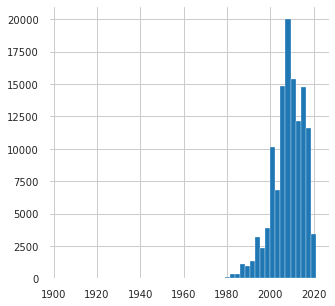

In [154]:
data['model_date'].hist(figsize=(5,5), bins=50)

У нас достаточно сильный перекос моделей на те, которые созданы после 2000. Но те модели, которые были выпущены ранее, могут являтся колекционными и мы их должны оставить, чтобы модель могла предсказывать их стоимость

In [155]:
num_cols.append('model_date')

### Model_name

Много уникальных значений - 705

In [156]:
data.model_name.value_counts()

OCTAVIA     2847
5ER         2663
FOCUS       2455
E_KLASSE    2191
PASSAT      2162
            ... 
LANTIS         1
CONTOUR        1
C-HR           1
Fabia          1
JUSTY          1
Name: model_name, Length: 1264, dtype: int64

Заполним пробелы noDate, возможно в одном из признаков, которых мы удалили ранее, есть информация про модель. В дальнейшим, можно будем проверить

In [157]:
data.model_name = data.model_name.fillna('noDate')

In [158]:
cat_cols.append('model_name')

### Name

Судя по данным, Name это смесь признаков, которые у нас уже есть. Поверим ещё раз и удалим, если это так. Можно было бы дозаполнить пропуски в model_name, где возможно, но это весьма долгая и кропотливая работа, в будущем стоит попробовать

In [159]:
data.name.value_counts()

1.6 AT (110 л.с.)           1715
2.0 AT (150 л.с.)           1697
1.6 AT (123 л.с.)           1292
1.6 MT (105 л.с.)           1177
1.6 MT (110 л.с.)            978
                            ... 
6.0 MT (405 л.с.)              1
Infiniti FX FX35 I (S50)       1
3.0 MT (324 л.с.)              1
7.4 AT (233 л.с.) 4WD          1
XC 2.4 AT (193 л.с.) 4WD       1
Name: name, Length: 5371, dtype: int64

In [160]:
data = data.drop('name',axis=1)

### Number_of_doors

In [161]:
data.number_of_doors.value_counts()

5.0    69745
4.0    47374
2.0     3114
3.0     2851
0.0        2
Name: number_of_doors, dtype: int64

Видим, что есть 2 машины без дверей, посмотрим в каких строках они находятся

In [162]:
data.number_of_doors.sort_values()

121800    0.0
16944     0.0
40065     2.0
13629     2.0
9302      2.0
         ... 
53536     5.0
53535     5.0
53534     5.0
53532     5.0
123086    5.0
Name: number_of_doors, Length: 123086, dtype: float64

In [163]:
data.iloc[16944]

body_type                  кабриолет
brand                       MERCEDES
color                          white
engine_displacement              5.3
engine_power                      32
fuel_type                     бензин
mileage                        48000
model_date                      1904
model_name                   SIMPLEX
number_of_doors                    0
production_date                 1904
vehicle_transmission    механическая
owners                    1 владелец
licence                     Оригинал
type_of_drive                 задний
steering_wheel                Правый
сustoms                   Растаможен
sample                             0
price                              0
description_len                  785
real_photo                      True
Name: 16944, dtype: object

In [164]:
data.iloc[121800]

body_type                 родстер
brand                    MERCEDES
color                       white
engine_displacement             2
engine_power                  388
fuel_type                  бензин
mileage                     56000
model_date                   2008
model_name              SL_KLASSE
number_of_doors                 2
production_date              2008
vehicle_transmission    AUTOMATIC
owners                          2
licence                  ORIGINAL
type_of_drive              задний
steering_wheel               LEFT
сustoms                      True
sample                          1
price                     2.2e+06
description_len               491
real_photo                  False
Name: 121801, dtype: object

У данных модели действительно нет дверей

In [165]:
cat_cols.append('number_of_doors')

### Production_date

Нет пустых значений, уникальных значений 81. Сильная корреляция с Model_date. В дальнейшим можем рассмотерть данные признаки для создания новых

In [166]:
data.production_date.value_counts()

2020    11453
2008     9633
2012     9448
2011     8787
2013     8122
        ...  
1955        1
1924        1
1954        1
1923        1
1951        1
Name: production_date, Length: 81, dtype: int64

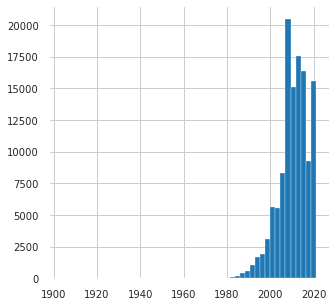

In [167]:
data['production_date'].hist(figsize=(5,5), bins=50)

Тоже самое, что и с model_date, сильный перекос машин в сторону произведённых после 2000. Но те машины, которые были выпущены ранее, могут являтся колекционными и мы их должны оставить, чтобы модель могла предсказывать их стоимость

In [168]:
num_cols.append('production_date')

### Vehicle_transmission

In [169]:
data.vehicle_transmission.value_counts()

AUTOMATIC           47774
MECHANICAL          24971
автоматическая      20476
ROBOT                7517
механическая         7390
VARIATOR             6591
вариатор             4265
роботизированная     4102
Name: vehicle_transmission, dtype: int64

In [170]:
change_transmission = {
               'автоматическая': 'AUTOMATIC',
               'механическая': 'MECHANICAL',
               'вариатор': 'VARIATOR',
               'роботизированная': 'ROBOT'
                }
data = data.replace({'vehicle_transmission': change_transmission})

In [171]:
data.vehicle_transmission.value_counts()

AUTOMATIC     68250
MECHANICAL    32361
ROBOT         11619
VARIATOR      10856
Name: vehicle_transmission, dtype: int64

In [172]:
cat_cols.append('vehicle_transmission')

### Owners

In [173]:
data['owners'].value_counts()

3.0            35861
2.0            20763
1.0            18231
3 или более    16415
1 владелец      9459
2 владельца     9270
1 владелец       507
2 владельца      349
Name: owners, dtype: int64

In [174]:
data['owners'].isnull().sum()

12231

In [175]:
# Посмотрим количество владельцов относительно года выпуск
data[data.owners.isnull()== True].production_date.value_counts()

2020    10856
2019     1064
2021      228
2018       82
2017        1
Name: production_date, dtype: int64

Скорее всего так как они достаточно новые, это может быть либо 1 владелец, либо вообще ноль. Заменим на ноль, чтобы всё-таки иметь отдельную категорию тех машин, у которых не было ещё владельцев

In [176]:
data.owners = data.owners.fillna('0')

In [177]:
data['owners'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', '0',
       '1 владелец', '2 владельца', 3.0, 1.0, 2.0], dtype=object)

In [178]:
# Создаем словарь с кодировкой значений в числовые
owners_dict = {"3 или более": 3, "1\xa0владелец": 1, "1 владелец": 1, "2\xa0владельца": 2, "2 владельца": 2}
data['owners'].replace(to_replace=owners_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [179]:
# Преобразуем owners в int
data['owners'] = data['owners'].astype('int64')

In [180]:
data['owners'].value_counts()

3    52276
2    30382
1    28197
0    12231
Name: owners, dtype: int64

In [181]:
cat_cols.append('owners')

### Licence

Всего 4 уникальных значения и 591 пропуск

In [182]:
data.licence.value_counts()

ORIGINAL     76189
Оригинал     31270
DUPLICATE    10307
Дубликат      4729
Name: licence, dtype: int64

In [183]:
change_passport = {
               'Оригинал': 'ORIGINAL',
               'Дубликат': 'DUPLICATE'
                }
data = data.replace({'licence': change_passport})


In [184]:
data.licence.isnull().sum()

591

In [185]:
data.licence = data.licence.fillna('ORIGINAL')# заполним пропуск наиболее частым значением

In [186]:
# Преобразуем значения в колонке licence
data['licence'] = data['licence'].apply(lambda x: 1 if x == 'ORIGINAL' else 0).astype('int8')

In [187]:
#определяем в бинарные признаки
bin_cols.append('licence')

### Type_of_drive

3 уникальных значения, 234 пропуска

In [188]:
data.type_of_drive.value_counts()

передний    62331
полный      49406
задний      11116
Name: type_of_drive, dtype: int64

In [189]:
data.type_of_drive = data.type_of_drive.fillna('передний')# заполним пропуск наиболее частым значением, но можно будет посмотреть удаленные признаки, возможно там бдет эта информация

In [190]:
#определяем его в "категориальные"
cat_cols.append('type_of_drive')

### Steering_wheel

4 уникальных значения, 233 пропуска

In [191]:
data.steering_wheel.value_counts()

LEFT      85077
Левый     34554
RIGHT      1776
Правый     1446
Name: steering_wheel, dtype: int64

In [192]:
change_wheel = {
               'Левый': 'LEFT',
               'Правый': 'RIGHT'
                }
data = data.replace({'steering_wheel': change_wheel})

In [193]:
data.steering_wheel = data.steering_wheel.fillna('LEFT')# заполним пропуск наиболее частым значением

In [194]:
# Преобразуем значения в колонке
data['steering_wheel'] = data['steering_wheel'].apply(lambda x: 1 if x == 'LEFT' else 0).astype('int8')

In [195]:
data.steering_wheel.value_counts()

1    119864
0      3222
Name: steering_wheel, dtype: int64

In [196]:
#определяем в бинарные признаки
bin_cols.append('steering_wheel')

## Customs

In [197]:
data.сustoms.value_counts()

True          86853
Растаможен    35998
Name: сustoms, dtype: int64

In [198]:
data.сustoms.isnull().sum()

235

Так как значение всего одно, можем удалить признак

In [199]:
data = data.drop('сustoms',axis=1)

## Feature Engineering

In [200]:
#создадим новые признаки на основе существующих: количество лет от производства и возраст модели
data['car_age'] = 2021 - data.production_date
data['model_age'] = 2021 - data.model_date

In [201]:
#определим эти признаки в числовые
num_cols.append('car_age')
num_cols.append('model_age')

## EDA

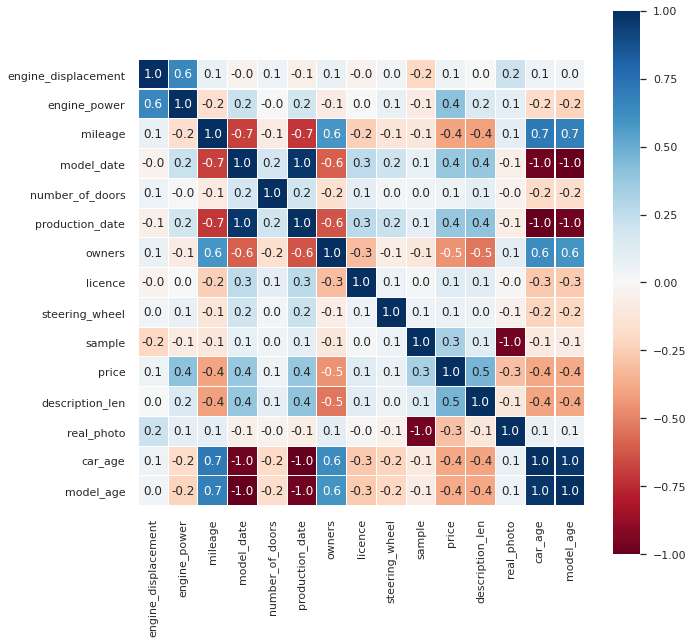

In [202]:
sn.set(font_scale=1)
plt.subplots(figsize=(10, 10))
sn.heatmap(data.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

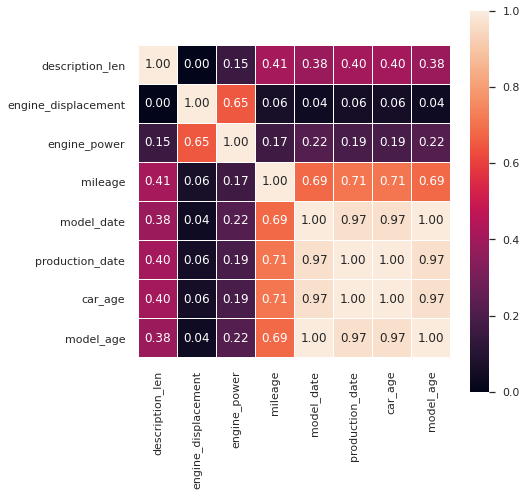

In [203]:
# Посмотрим матрицу коэффициента корреляции численных признаков
sn.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sn.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1)

Помимо очевидной кореляции между production_date, model_date,car_age и model_age. Также с данными показателями скорелирован mileage

Посмотрим распределение целевой переменной числовых признаков

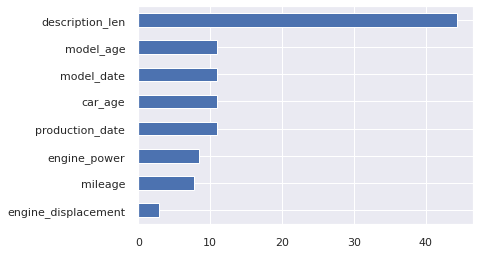

In [204]:
imp_num = pd.Series(f_classif(data[num_cols], data['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

description_len самый значимый признак из числовых, model_age самый важный из 4 скореллированных признаков, удалим 3 других

In [205]:
num_cols.remove('car_age')
num_cols.remove('production_date')
num_cols.remove('model_date')

In [206]:
data = data.drop('production_date',axis=1)
data = data.drop('car_age',axis=1)
data = data.drop('model_date',axis=1)

In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123086 entries, 0 to 123086
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             123086 non-null  object 
 1   brand                 123086 non-null  object 
 2   color                 123086 non-null  object 
 3   engine_displacement   123086 non-null  float64
 4   engine_power          123086 non-null  int64  
 5   fuel_type             123086 non-null  object 
 6   mileage               123086 non-null  int64  
 7   model_name            123086 non-null  object 
 8   number_of_doors       123086 non-null  float64
 9   vehicle_transmission  123086 non-null  object 
 10  owners                123086 non-null  int64  
 11  licence               123086 non-null  int8   
 12  type_of_drive         123086 non-null  object 
 13  steering_wheel        123086 non-null  int8   
 14  sample                123086 non-null  int64  
 15  

In [208]:
bin_cols

['real_photo', 'licence', 'steering_wheel']

In [209]:
cat_cols

['body_type',
 'brand',
 'color',
 'fuel_type',
 'model_name',
 'number_of_doors',
 'vehicle_transmission',
 'owners',
 'type_of_drive']

In [210]:
num_cols

['description_len',
 'engine_displacement',
 'engine_power',
 'mileage',
 'model_age']

In [211]:
# трансформируем бинарные признаки

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
data.sample(10)

body_type       brand   color  engine_displacement  engine_power  \
24202         седан  VOLKSWAGEN  silver                  1.6           105   
81630         седан      NISSAN  silver                  1.6           107   
114018  внедорожник  LAND_ROVER   brown                  2.0           510   
57204         седан        FORD  silver                  1.6           105   
65297         седан     HYUNDAI   black                  1.4           107   
66327   внедорожник    INFINITI    grey                  2.0           295   
88639         седан        OPEL   black                  2.0           220   
26334   внедорожник  VOLKSWAGEN   white                  3.0           224   
116786        седан    MERCEDES   black                  2.0           272   
16275   внедорожник    MERCEDES   black                  4.0           476   

       fuel_type  mileage      model_name  number_of_doors  \
24202     бензин    86248           JETTA              4.0   
81630     бензин   188000  ALMERA_CLASSIC              4.0   
114018    бензин   147000     RANGE_ROVER              5.0   
57204     бензин   131000           FOCUS              4.0   
65297     бензин    83000         SOLARIS              4.0   
66327     бензин   110000              EX              5.0   
88639     бензин   130000        INSIGNIA              4.0   
26334     дизель   240000         TOUAREG              5.0   
116786    бензин    98000        E_KLASSE              4.0   
16275     бензин    37783   AMG_GLC_COUPE              5.0   

       vehicle_transmission  owners  licence type_of_drive  steering_wheel  \
24202             AUTOMATIC       2        1      передний               1   
81630            MECHANICAL       3        1      передний               1   
114018            AUTOMATIC       3        1        полный               1   
57204            MECHANICAL       3        0      передний               1   
65297            MECHANICAL       2        1      передний               1   
66327             AUTOMATIC       3        0        полный               1   
88639             AUTOMATIC       3        1      передний               1   
26334             AUTOMATIC       3        1        полный               1   
116786            AUTOMATIC       2        1        полный               1   
16275             AUTOMATIC       2        1        полный               1   

        sample      price  description_len  real_photo  model_age  
24202        0        0.0              445           1       11.0  
81630        1   250000.0              173           0       15.0  
114018       1  1150000.0                1           0       12.0  
57204        1   430000.0               88           0       10.0  
65297        1   600000.0              112           0        7.0  
66327        1   490000.0              276           0       14.0  
88639        1   480000.0              895           0       13.0  
26334        0        0.0               70           1       19.0  
116786       1   999000.0                1           0       12.0  
16275        0        0.0              551           1        5.0

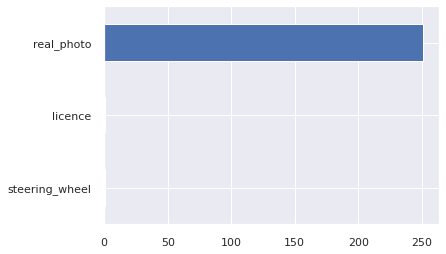

In [212]:
imp_bin = pd.Series(f_classif(data[bin_cols], data['price'])[0], index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

Наличие фотографий действительно сильно взаимосвязан с ценой

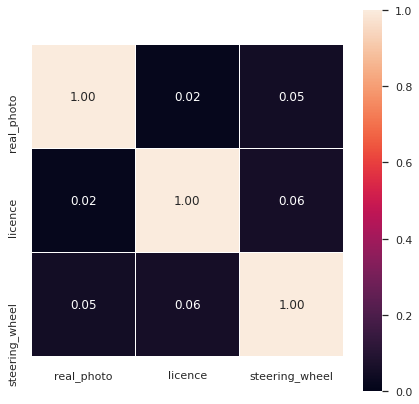

In [213]:
# Посмотрим матрицу коэффициента корреляции бинарных признаков
sn.set(font_scale = 1)
fig, axis = plt.subplots(figsize=(7,7))
sn.heatmap(data[bin_cols].corr().abs(), vmin=0, vmax=1, square=True,
           annot=True, fmt=".2f", linewidths=0.1)

Признаки не скореллированы

In [214]:
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

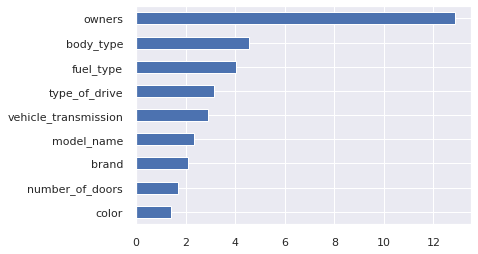

In [215]:
imp_cat = pd.Series(f_classif(data[cat_cols], data['price'])[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Количество владельце самый значимый признак из категориальных

## Label Encoding

In [216]:
data

body_type  brand  color  engine_displacement  engine_power  fuel_type  \
0               6     29      2                  1.2           105          0   
1               6     29      1                  1.6           110          0   
2               6     29      6                  1.8           152          0   
3               6     29      3                  1.6           110          0   
4               6     29     14                  1.8           152          0   
...           ...    ...    ...                  ...           ...        ...   
123082          8     30      1                  2.7           163          3   
123083          8     30     12                  2.7           163          3   
123084          8     30      1                  2.0           149          3   
123085          8     30      6                  2.0           149          3   
123086          8     30     14                  2.0           149          3   

        mileage  model_name  number_of_doors  vehicle_transmission  owners  \
0         74000         781                4                     2       3   
1         60563         781                4                     1       1   
2         88000        1044                4                     2       1   
3         95000         781                4                     0       1   
4         58536         781                4                     0       1   
...         ...         ...              ...                   ...     ...   
123082   260000         921                4                     0       3   
123083   300000         921                4                     0       3   
123084   126000        1034                4                     0       1   
123085    84000        1034                4                     0       3   
123086   144000        1034                4                     0       2   

        licence  type_of_drive  steering_wheel  sample      price  \
0             1              1               1       0        0.0   
1             1              1               1       0        0.0   
2             1              1               1       0        0.0   
3             1              1               1       0        0.0   
4             1              1               1       0        0.0   
...         ...            ...             ...     ...        ...   
123082        1              2               1       1   450000.0   
123083        1              2               1       1   485000.0   
123084        1              2               1       1  1090000.0   
123085        1              2               1       1  1180000.0   
123086        1              2               1       1  1075000.0   

        description_len  real_photo  model_age  
0                  1001           1        8.0  
1                  2609           1        4.0  
2                  1001           1        8.0  
3                  1676           1        8.0  
4                  2365           1       13.0  
...                 ...         ...        ...  
123082              197           0       17.0  
123083              522           0       17.0  
123084              201           0        8.0  
123085             1682           0        8.0  
123086              332           0        8.0  

[123086 rows x 19 columns]

In [217]:
# Преобразуем категориальные признаки
data = pd.get_dummies(data, columns=cat_cols)

In [218]:
# выполним стандартизацию численных переменных
#data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns=num_cols)

Результаты от стандартизации хуже

In [219]:
data

engine_displacement  engine_power  mileage  licence  steering_wheel  \
0                       1.2           105    74000        1               1   
1                       1.6           110    60563        1               1   
2                       1.8           152    88000        1               1   
3                       1.6           110    95000        1               1   
4                       1.8           152    58536        1               1   
...                     ...           ...      ...      ...             ...   
123082                  2.7           163   260000        1               1   
123083                  2.7           163   300000        1               1   
123084                  2.0           149   126000        1               1   
123085                  2.0           149    84000        1               1   
123086                  2.0           149   144000        1               1   

        sample      price  description_len  real_photo  model_age  ...  \
0            0        0.0             1001           1        8.0  ...   
1            0        0.0             2609           1        4.0  ...   
2            0        0.0             1001           1        8.0  ...   
3            0        0.0             1676           1        8.0  ...   
4            0        0.0             2365           1       13.0  ...   
...        ...        ...              ...         ...        ...  ...   
123082       1   450000.0              197           0       17.0  ...   
123083       1   485000.0              522           0       17.0  ...   
123084       1  1090000.0              201           0        8.0  ...   
123085       1  1180000.0             1682           0        8.0  ...   
123086       1  1075000.0              332           0        8.0  ...   

        vehicle_transmission_1  vehicle_transmission_2  \
0                            0                       1   
1                            1                       0   
2                            0                       1   
3                            0                       0   
4                            0                       0   
...                        ...                     ...   
123082                       0                       0   
123083                       0                       0   
123084                       0                       0   
123085                       0                       0   
123086                       0                       0   

        vehicle_transmission_3  owners_0  owners_1  owners_2  owners_3  \
0                            0         0         0         0         1   
1                            0         0         1         0         0   
2                            0         0         1         0         0   
3                            0         0         1         0         0   
4                            0         0         1         0         0   
...                        ...       ...       ...       ...       ...   
123082                       0         0         0         0         1   
123083                       0         0         0         0         1   
123084                       0         0         1         0         0   
123085                       0         0         0         0         1   
123086                       0         0         0         1         0   

        type_of_drive_0  type_of_drive_1  type_of_drive_2  
0                     0                1                0  
1                     0                1                0  
2                     0                1                0  
3                     0                1                0  
4                     0                1                0  
...                 ...              ...              ...  
123082                0                0                1  
123083                0                0                1  
123084                0                0    

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123086 entries, 0 to 123086
Columns: 1366 entries, engine_displacement to type_of_drive_2
dtypes: float64(3), int64(7), uint8(1356)
memory usage: 169.5 MB


## Train Split

In [221]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
y = y/1.3 #согласно автостату цены увеличились на 30%, значит уменьшим нашу целевую переменную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [222]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train


In [223]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engine_displacement'].map(tmp_train.groupby('engine_displacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 91.89%


# Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


# Fit

In [224]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [225]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 17.36%


In [226]:
# попробуем подобрать параметры 
cb = CatBoostRegressor(iterations = 20000,
                       learning_rate = 0.15,
                       depth = 9,
                       random_seed = RANDOM_SEED,
                       eval_metric = 'MAPE',
                       custom_metric = ['R2', 'MAE'],
                       silent=True
                       )
cb.fit(X_train, y_train,
         eval_set = (X_test, y_test),
         verbose_eval = 0,
         use_best_model = True
         )

cb.save_model('catboost_single_model_baseline.cb')
predict = cb.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.93%


### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    


In [227]:
model_log = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model_log.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         )

model_log.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model_log.predict(X_test))
predict_submission = np.exp(model_log.predict(test_data))
VERSION = 4
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 13.78%


# GradientBoosting

In [228]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(min_samples_split = 2,
                               learning_rate = 0.03,
                               max_depth = 10,
                               n_estimators = 1000)
gb.fit(X_train, y_train)
predict = gb.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.43%


# Random Forest

In [229]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train, np.log(y_train+1))
predict_submission = np.exp(rf.predict(test_data))
VERSION = 5
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test)))) * 100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


Точность модели по метрике MAPE: 13.79%


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


# xgboost

In [230]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                           colsample_bytree=0.5,
                           learning_rate=0.05,
                           max_depth=12,
                           alpha=1,
                           n_estimators=1000)
xgb_reg.fit(X_train, np.log(y_train))
print(f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, np.exp(xgb_reg.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 13.10%


Лучшие показатели у xgboost 13,10, на втором месте CatBoost с логарифмом 13.78 RandomForest 13,79

# Stacking

Cтекинг на базе GradientBoostingRegressor c CatBoostingRegressor и XGBRegressor.

In [231]:
from sklearn.ensemble import StackingRegressor

estimators = [('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror',
                           colsample_bytree=0.5,
                           learning_rate=0.05,
                           max_depth=12,
                           alpha=1,
                           n_estimators=1000)),
              ('model', CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True))]

st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=GradientBoostingRegressor(
                                min_samples_split=2,
                                learning_rate=0.03,
                                max_depth=10,
                                n_estimators=1000))


st_ensemble.fit(X_train, np.log(y_train))

predict_ensemble = np.exp(st_ensemble.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")


Точность модели по метрике MAPE: 13.69%


Cтекинг на базе RandomForestRegressor c CatBoostingRegressor и XGBRegressor.

In [232]:
from sklearn.ensemble import StackingRegressor

estimators = [('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror',
                           colsample_bytree=0.5,
                           learning_rate=0.05,
                           max_depth=12,
                           alpha=1,
                           n_estimators=1000)),
              ('model', CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True))]

st_ensemble_2 = StackingRegressor(estimators=estimators,
                                final_estimator=RandomForestRegressor(
                                random_state = RANDOM_SEED,
                                n_jobs = -1,
                                verbose = 1))


st_ensemble_2.fit(X_train, np.log(y_train))

predict_ensemble_2 = np.exp(st_ensemble_2.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble_2))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Точность модели по метрике MAPE: 14.65%


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


Как мы видим, несмторя на стекинг данных с использованием моделей с минимальными показателями, лучшей моделью является xgboost с результатом 13.10%

In [233]:
predict_submission = np.exp(xgb_reg.predict(test_data))

# Submission

In [234]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v3.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  5.951086e+05
1  1100549428  9.145642e+05
2  1100658222  8.772886e+05
3  1100937408  6.942426e+05
4  1101037972  7.158835e+05
5  1100912634  7.162379e+05
6  1101228730  6.373706e+05
7  1100165896  3.811038e+05
8  1100768262  1.467265e+06
9  1101218501  7.580391e+05

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML


Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing